In [1]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                      1. open   2. high    3. low  4. close  5. volume
date                                                                  
2022-02-02 20:00:00  310.0500  310.1101  310.0500    310.11     1364.0
2022-02-02 19:59:00  310.0501  310.0700  310.0501    310.07     1254.0


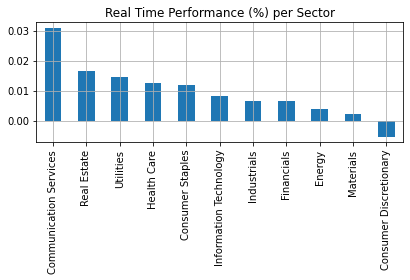

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

137.2500


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
129     DGRO
130     TD6C
131     TDG0
132    PTTRX
133      NaN
Name: Ticker, Length: 134, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb
01-Feb - UP (23.7900)
11-Feb
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb
16-Mar
04-Feb
17-Feb
27-Jan - UP (319.1700)
09-Feb
14-Mar
09-Mar
17-Feb
02-Mar
23-Feb
01-Feb
03-Feb
14-Feb
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb
22-Feb
09-Feb
09-Feb
28-Feb
23-Feb
15-Feb
16-Feb
26-Jan - UP (228.2200)
16-Feb
21-Feb
28-Feb
23-Feb
07-Feb
22-Feb
14-Feb
08-Feb
28-Feb
08-Feb
03-Feb
08-Feb
10-Feb
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb
21-Mar
08-Mar
02-Mar
22-Feb
10-Feb
22-Feb
01-Feb
02-Feb
23-Feb
14-Feb
16-Feb
15-Feb
23-Feb
17-Feb
01-Mar
28-Feb
23-Feb
14-Feb
10-Feb
21-Feb
01-Feb - UP (128.4400)
18-Feb
01-Mar
02-Feb
21-Feb
01-Mar
22-Mar
14-Feb
22-Feb
23-Feb
23-Feb
08-Feb
09-Feb
22-Feb
23-Feb
03-Feb
09-Feb
16-Feb
27-Jan - UP (170.3300)
26-Jan - UP (528.6900)
22-Mar
17-Mar
23-Feb
01-Feb
03-Feb
10-Feb
23-Feb
09-Feb
28-Mar
10-Feb
22-Feb
02-Feb
14-Jan - DN (157.8900)
10-Feb
28-Feb
21-Feb
16-Feb
20-Jan - DN (269.5300)
18-Jan - DN (103.3400)


In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [52]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter"]
    if any(word in title for word in words1) and any(word in title for word in words2):
        #print(True)
        return True
    return False

In [30]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [31]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [32]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [33]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [34]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [35]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [36]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [37]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE", "IS"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "%" else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [38]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [39]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [155]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 27

FOR TABLE 0

TABLE DESCRIPTION:  
 CROWDSTRIKE REPORTS FISCAL FIRST QUARTER 2020 FINANCIAL RESULTS 

ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  · NaN  Total revenue of $96.1 million, grew 103% year...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
  · 
 
 
 
 TOTAL REVENUE OF $96.1 MILLION, GREW 103% YEAR-OVER-YEAR
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  · NaN  Subscription revenue of $86.0 million, grew 11...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  
 
  · 
 
 
 
 SUBSCRIPTION REVENUE OF $86.0 MILLION,  GREW 116% YEAR-OVER-YEAR
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  · NaN  Record ARR of $364.6 million, grew 114% year-o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  
 FIRST QUARTER FISCAL 2020 FINAN

FINAL REPORT
                                   METRIC  \
4                         COST OF REVENUE   
5                     SALES AND MARKETING   
6                RESEARCH AND DEVELOPMENT   
7              GENERAL AND ADMINISTRATIVE   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
4                                             $368   
5                                             1518   
6                                              681   
7                                             1185   
8                                            $3752   

  THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS)  
4                                             $109  
5                                              773  
6                                              448  
7                                              389  
8                                            $1719  

FOR TABLE 20

TABLE DESCRIPTION:  
   

ORIGINAL TABLE  20
             

{1: [2], 4: [5]}

FINAL REPORT
                                            METRIC  \
3                        GAAP SUBSCRIPTION REVENUE   
5                   GAAP SUBSCRIPTION GROSS PROFIT   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8               NON-GAAP SUBSCRIPTION GROSS PROFIT   
10                  GAAP SUBSCRIPTION GROSS MARGIN   
12              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
3                                            $85990   
5                                            $62299   
6                                               270   
7                                               104   
8                                            $62673   
10                                              72%   
12                                              73%   

   THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS)  
3                                        

FINAL REPORT
                                               METRIC  \
4                                  GAAP TOTAL REVENUE   
6   GAAP NET CASH PROVIDED BY (USED IN) OPERATING ...   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
9                                      FREE CASH FLOW   
11  GAAP NET CASH PROVIDED BY (USED IN) INVESTING ...   
12  GAAP NET CASH PROVIDED BY (USED IN) FINANCING ...   
14  GAAP NET CASH PROVIDED BY (USED IN) OPERATING ...   
15  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
16  LESS CAPITALIZED INTERNAL-USE SOFTWARE AS A PE...   
17                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
4                                            $96077   
6                                              1415   
7                                           (15541)   
8                                            (1984)   
9                          

In [40]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [41]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [42]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [43]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

Earning for stock UPST will be released later on 2022-02-15
None


In [44]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [55]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Earning for stock ENB will be released later on 2022-02-11
Quote for stock ENB on earning date 11-Feb not generated yet
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Earning for stock KNSL will be released later on 2022-02-17
Quote for stock KNSL on earning date 17-Feb not generated yet
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Earning report for stock BMY on date 2022-02-04 does not exist, trying to fetch it
https://finance.yahoo.com/news/bristol-myers-squibb-reports-fourth-115900790.html
TRYING TO STORE REFINED CONTENT IN FILE ../../Su

Earning report for stock BMY fetching status True, filename BMY-2022-02-04_08-46-06.169727.txt
Earning report for stock BMY on date 2022-02-04 fetched, filename BMY-2022-02-04_08-46-06.169727.txt
Earning released for stock BMY PM
Get price diff for stock BMY from date 2022-02-04 and date 2022-02-03
Update Stock BMY with quote 04-Feb
Earning for stock APPN will be released later on 2022-02-17
Quote for stock APPN on earning date 17-Feb not generated yet
Quote for stock TEAM on earning date 27-Jan - UP (319.1700) already generated
Earning for stock CGC will be released later on 2022-02-09
Quote for stock CGC on earning date 09-Feb not generated yet
Earning for stock CRWD will be released later on 2022-03-14
Quote for stock CRWD on earning date 14-Mar not generated yet
Earning for stock DOCU will be released later on 2022-03-09
Quote for stock DOCU on earning date 09-Mar not generated yet
Earning for stock FVRR will be released later on 2022-02-17
Quote for stock FVRR on earning date 17-F

Update Stock SNAP with quote 03-Feb
Earning for stock UBER will be released later on 2022-02-09
Quote for stock UBER on earning date 09-Feb not generated yet
Earning for stock ROKU will be released later on 2022-02-16
Quote for stock ROKU on earning date 16-Feb not generated yet
Quote for stock AAPL on earning date 27-Jan - UP (170.3300) already generated
Quote for stock NOW on earning date 26-Jan - UP (528.6900) already generated
Earning for stock ADBE will be released later on 2022-03-22
Quote for stock ADBE on earning date 22-Mar not generated yet
Earning for stock FDX will be released later on 2022-03-17
Quote for stock FDX on earning date 17-Mar not generated yet
Earning for stock CRM will be released later on 2022-02-23
Quote for stock CRM on earning date 23-Feb not generated yet
Earning report for stock BABA on date 2022-02-03 does not exist, trying to fetch it
Earning report for stock BABA fetching status False, filename None
Quote for stock BABA on earning date 03-Feb not gene

In [46]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [48]:
stocks = get_earningDates(d, "TD")
print(stocks, "\n", len(stocks))

[['PINS', '03-Feb-2022'], ['WD', '03-Feb-2022'], ['SNAP', '03-Feb-2022'], ['AMZN', '03-Feb-2022']] 
 4


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [57]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [58]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [59]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [60]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [338]:
import json
org = "NET"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/NET/profile?p=NET
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-transactions?p=NET
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-roster?p=NET
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/holders?p=NET
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 6.50%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 87.32%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 93.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 839
https://finance.yahoo.com/quote/NET/analysis?p=NET
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 12/30/2020 1 1 -0.02
Table Number 2
FOUND
2 3/30/2021 1 2 -0.03
Table Number 2
FOUND
3 6/29/2021 1 3 -0.02
Table Number 2
FOUND
4 9/29/2021 1 4 0
Table Number 2
FOUND
1 12/30/2020 0 1 -0.03
Table Number 2
FOUND
2 3/30/2021 0 2 -0.03
Table Numb

In [42]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

6


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [61]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [62]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [63]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [64]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [65]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [66]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [67]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [68]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [69]:
def isBold(tag, ctext):
    if(tag.name == "b" or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [70]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tag))
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [71]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [72]:
def isPadLeft(item):
    if(item.name == "ul"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
    return False

In [73]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [84]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    if not txt:
        ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name != "ul" and item.parent.name != "ul"):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [75]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [82]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle)
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk])
                    f.write("\n")
        elif(len(ndata)>0):
            print(ndata)
            #print(" ".join(ndata))
            #print("\n")
            f.write("PG*** "+" ".join(ndata))
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr)
    f.write("\n")
    return possibleTblTitle

In [77]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    dollarCol = list()
    f.write("\n")
    f.write(tblStr)
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            continue
        nanCnt = 0
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                replc = ["NON-GAAP", "NON GAAP", "GAAP"]
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        break
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met and "PER SHARE" not in met and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met or "EPS" in met)):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
            else:
                header = header + " " + met
        elif(met == "TOTAL"):
            header = None
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr)
    f.write("\n")

In [78]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul"):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [90]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2021-12-07"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [87]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
url = "https://www.sec.gov/Archives/edgar/data/1583708/000158370821000018/sentineloneq322exhibit991.htm"
source = getPgSource(url)

In [88]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 8

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                          0                          1   \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                    Revenue                    Revenue   
3      Non-GAAP gross margin      Non-GAAP gross margin   
4  Non-GAAP operating margin  Non-GAAP operating margin   

                          2                          3   \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                    Revenue                    Revenue   
3      Non-GAAP gross margin      Non-GAAP gross margin   
4  Non-GAAP operating margin  Non-GAAP operating margin   

                          4                          5                6   \
0                        NaN                        NaN              NaN   
1                        NaN                        NaN  Q4 FY22Gu

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     COST OF REVENUE   
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                            RESEARCH AND DEVELOPMENT   
8                                 SALES AND MARKETING   
9                          GENERAL AND ADMINISTRATIVE   
10                           TOTAL OPERATING EXPENSES   
11                               LOSS FROM OPERATIONS   
12                                    INTEREST INCOME   
13                                   INTEREST EXPENSE   
14                        OTHER INCOME (EXPENSE), NET   
15             LOSS BEFORE PROVISION FOR INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                


FINAL REPORT
                                               METRIC  \
3                 CASH FLOW FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                      NON-CASH OPERATING LEASE COSTS   
9                    STOCK-BASED COMPENSATION EXPENSE   
10                                              OTHER   
11  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
12                                ACCOUNTS RECEIVABLE   
13                  PREPAID EXPENSES AND OTHER ASSETS   
14                DEFERRED CONTRACT ACQUISITION COSTS   
15                                   ACCOUNTS PAYABLE   
16                                ACCRUED LIABILITIES   
17                       ACCRUED PAYROLL AND BENEFITS   
18                        OPERATING LEASE LIABILITIES   
19               

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
3  GAAP NET CASH USED IN OPERATING ACTIVITIES   
4    LESS PURCHASES OF PROPERTY AND EQUIPMENT   
5      LESS CAPITALIZED INTERNAL-USE SOFTWARE   
6                              FREE CASH FLOW   
7       NET CASH USED IN INVESTING ACTIVITIES   
8   NET CASH PROVIDED BY FINANCING ACTIVITIES   

  THREE MONTHS ENDED OCTOBER 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
3                            $(17212)                            $(17769)   
4                              (1583)                              (1233)   
5                              (1881)                               (838)   
6                            $(20676)                            $(19840)   
7                             $(3984)                             $(2127)   
8                                $454                             $

In [89]:
allTables

{'TOTAL': 8,
 'PARSESUCCESS': [0, 1, 3, 4, 5, 7],
 'PARSEFAIL': [2, 6],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null,"12":null,"13":null,"14":null},{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":"Q4 FY22Guidance","7":"Q4 FY22Guidance","8":"Q4 FY22Guidance","9":null,"10":null,"11":null,"12":"Full Year FY22Guidance","13":"Full Year FY22Guidance","14":"Full Year FY22Guidance"},{"0":"Revenue","1":"Revenue","2":"Revenue","3":"Revenue","4":"Revenue","5":"Revenue","6":"$60-61 million","7":"$60-61 million","8":"$60-61 million","9":null,"10":null,"11":null,"12":"$199-200 million","13":"$199-200 million","14":"$199-200 million"},{"0":"Non-GAAP gross margin","1":"Non-GAAP gross margin","2":"Non-GAAP gross margin","3":"Non-GAAP gross margin","4":"Non-GAAP gross margin","5":"Non-GAAP gross margin","6":"62-63%","7":"62-63%","8":"62-63%","9":null,"10":null,"11":null,"12":"61-62%","13":"61-62%","14":"61-62

In [92]:
csym = "S"
#rptDest = "../../Summary/EDGAR/8-K/"+csym
#textFilename = rptDest+"/S_2021-12-07_EP.txt"
#testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
#testOne8KEdgarRpt(url, csym, None, source, allTables)

NOPAD*** Document.


SC*** Exhibit 99.1.


SC*** SentinelOne Announces Third Quarter Fiscal Year 2022 Financial Results.


SC*** Revenue increased 128% year-over-year.


SC*** ARR up 131% year-over-year.

NOPAD*** MOUNTAIN VIEW, Calif. - December 7, 2021 - SentinelOne, Inc. (NYSE: S) today announced financial results for the third quarter of fiscal year 2022 ended October 31, 2021.

NOPAD*** “Customers continue to choose Singularity XDR because of our protection, detection, response, and automation capabilities. Our business is performing extremely well. Q3 marks the third consecutive quarter of triple digit ARR growth,” said Tomer Weingarten, CEO of SentinelOne. “We continued to make progress across all aspects of our growth strategy outlined during the IPO.”.

NOPAD*** “Our ARR growth accelerated to 131% year-over-year as we delivered ARR of $237 million,” said Dave Bernhardt, CFO of SentinelOne. “The strength was broad based, including new and existing customers as well as large and

In [85]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [86]:
csym = "S"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/S'
1583708
8K URL https://www.sec.gov/Archives/edgar/data/1583708/0001583708-21-000012-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1583708/000158370821000012/sentineloneq222exhibit991.htm
NUMBER OF TABLES 12

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                          0                          1   \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                    Revenue                    Revenue   
3      Non-GAAP gross margin      Non-GAAP gross margin   
4  Non-GAAP operating margin  Non-GAAP operating margin   

                          2                          3   \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                    Revenue                    Revenue   
3      Non-GAAP gross margin      Non-GA

40          $520560  

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0  \
0                                                NaN   
1  SENTINELONE, INC. CONDENSED CONSOLIDATED STATE...   

                                                   1  \
0                                                NaN   
1  SENTINELONE, INC. CONDENSED CONSOLIDATED STATE...   

                                                   2  
0                                                NaN  
1  SENTINELONE, INC. CONDENSED CONSOLIDATED STATE...  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  SENTINELONE, INC.  CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (IN THOUSANDS, EXCEPT SHARE AND PER SHARE DATA) (UNAUDITED)
ORIGINAL TABLE  3
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                    

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                 CASH FLOW FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                      NON-CASH OPERATING LEASE COSTS   
9                    STOCK-BASED COMPENSATION EXPENSE   
10                                              OTHER   
11  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
12                                ACCOUNTS RECEIVABLE   
13          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
14                DEFERRED CONTRACT ACQUISITION COSTS   
15                                   ACCOUNTS PAYABLE   
16                                ACCRUED LIABILITIES   
17                       ACCRUED PAYROLL AND BENEFITS   
18 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                           METRIC  \
3                                    GAAP REVENUE   
4                               GAAP GROSS PROFIT   
5            ADD STOCK-BASED COMPENSATION EXPENSE   
6  ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                           NON-GAAP GROSS PROFIT   
8                               GAAP GROSS MARGIN   
9                           NON-GAAP GROSS MARGIN   

  THREE MONTHS ENDED JULY 31, 2021 THREE MONTHS ENDED JULY 31, 2020  \
3                           $45750                           $20674   
4                           $26962                           $13131   
5                              840                               65   
6                              558                              nan   
7                           $28360                           $13196   
8                              59%            

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                           METRIC  \
3                                    GAAP REVENUE   
4                       GAAP LOSS FROM OPERATIONS   
5            ADD STOCK-BASED COMPENSATION EXPENSE   
6  ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                   NON-GAAP LOSS FROM OPERATIONS   
8                           GAAP OPERATING MARGIN   
9                       NON-GAAP OPERATING MARGIN   

  THREE MONTHS ENDED JULY 31, 2021 THREE MONTHS ENDED JULY 31, 2020  \
3                           $45750                           $20674   
4                         $(67155)                         $(22561)   
5                            21393                             1588   
6                              766                              nan   
7                         $(44996)                         $(20973)   
8                     

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                              METRIC  \
3                                  NON-GAAP NET LOSS   
4  WEIGHTED-AVERAGE SHARES USED IN COMPUTING PRO ...   
5  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
6  PRO FORMA ADJUSTMENT TO REFLECT CONVERSION OF ...   
7  WEIGHTED-AVERAGE SHARES USED IN COMPUTING PRO ...   
8  PRO FORMA NET LOSS PER SHARE ATTRIBUTABLE TO C...   

  THREE MONTHS ENDED JULY 31, 2021 SIX MONTHS ENDED JULY 31, 2021  
3                         $(46004)                       $(94527)  
4                              nan                            nan  
5                         65154671                       54252916  
6                        169787200                      169787200  
7                        234941871                      224040116  
8                          $(0.20)                        $(0.42)  

FOR TABLE 11

TABLE DESCRIPTION:  
ORIGINAL TABLE  11
                            

NOPAD*** Document.


SC*** Exhibit 99.1.


SC*** SentinelOne Announces Second Quarter Fiscal Year 2022 Financial Results.


SC*** Revenue increased 121% year-over-year.


SC*** ARR up 127% year-over-year.

NOPAD*** MOUNTAIN VIEW, Calif. - September 8, 2021 - SentinelOne, Inc. (NYSE: S) today announced financial results for the second quarter of fiscal year 2022 ended July 31, 2021.

NOPAD*** “We’re devoted to protecting our customers and our way of life from cyberattacks in an increasingly digital society. Cybersecurity must be autonomous - that’s what we’ve built. It must perform at a faster speed, greater scale, and higher accuracy than what exists today,” said Tomer Weingarten, Co-Founder and CEO of SentinelOne. “Our IPO was a significant milestone and is only the beginning of the opportunity in front of us. I’m pleased with the success and growth we delivered in Q2.”.

NOPAD*** “SentinelOne executed extremely well in Q2. Our annualized recurring revenue reached $198 million, with g

In [224]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [225]:
csym = "CRWD"
storeEdgarRpt(csym)

1535527
TRYING TO WRITE TEXT DATA FOR CRWD, report type 10-Q, date filed 2019-07-19
TRYING TO WRITE RISKS DATA FOR CRWD, report type 10-Q, date filed 2019-07-19
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR CRWD, report type 10-Q, date filed 2019-07-19
NUMBER OF TABLES 222

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ​                                                  ​
1  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ​                                                  ​
1  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0    1  \
0                                                  ​    ​  

0 NaN  o  the expected date of the expiration of the loc...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                                    0    1          2  \
0                                                   ​    ​          ​   
1                                                   ​  NaN  April 30,   
2                                                   ​  NaN       2019   
3                                              Assets  NaN          ​   
4                                     Current assets:  NaN          ​   
5                           Cash and cash equivalents    ​          $   
6                               Marketable securities    ​        NaN   
7   Accounts receivable, net of allowance for doub...    ​        NaN   
8        Deferred contract acquisition costs, current    ​        NaN   
9           Prepaid expenses and other current assets    ​        NaN   
10                          

{2: [3], 5: [6]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                           OTHER COMPREHENSIVE LOSS   
6           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
7  UNREALIZED LOSS ON AVAILABLE-FOR-SALE SECURITI...   
8                           OTHER COMPREHENSIVE LOSS   
9                           TOTAL COMPREHENSIVE LOSS   

  ​ THREE MONTHS ENDED APRIL 30, 2019 ​ THREE MONTHS ENDED APRIL 30, 2018  
4                            $(25977)                            $(33617)  
5                                 nan                                 nan  
6                               (280)                               (332)  
7                                 (4)                                 nan  
8                               (284)                               (332)  
9                            $(26261)                            $(33949)  

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGI


FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                   AMORTIZATION OF INTANGIBLE ASSETS   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9   CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
10                    ALLOWANCE FOR DOUBTFUL ACCOUNTS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12  ACCRETION OF MARKETABLE SECURITIES PURCHASED A...   
13                                              OTHER   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16                DEFERRED CONTRACT ACQUISITION COSTS   
17                  PREPAID EXPENSES AND OTHER ASSETS   
18                                   ACCOUNTS PAYABLE   
19     ACCRUED EX


FINAL REPORT
                                            METRIC  \
5   CONDENSED CONSOLIDATED STATEMENT OF OPERATIONS   
6                                              NaN   
7                                          REVENUE   
8                               OPERATING EXPENSES   
9                              SALES AND MARKETING   
10                                             NaN   
11                                        NET LOSS   
12                                             NaN   
13           NET LOSS PER SHARE, BASIC AND DILUTED   

   ​ THREE MONTHS ENDED APRIL 30, 2019 AS REPORTED (ASC 606) (IN THOUSANDS)  \
5                                                 nan                         
6                                                 nan                         
7                                              $96077                         
8                                                 nan                         
9                                               56


FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                   CASH EQUIVALENTS    
6                                  MONEY MARKET FUNDS   
7                           CORPORATE DEBT SECURITIES   
8                                       US TREASURIES   
9                              TOTAL CASH EQUIVALENTS   
10                              MARKETABLE SECURITIES   
11                          CORPORATE DEBT SECURITIES   
12                                      US TREASURIES   
13                        TOTAL MARKETABLE SECURITIES   
14                                       TOTAL ASSETS   
15                                          LIABILITY   
16  CONTINGENT CONSIDERATION RELATED TO BUSINESS C...   
17  REDEEMABLE CONVERTIBLE PREFERRED STOCK WARRANT...   
18                                  TOTAL LIABILITIES   

   ​ APRIL 30, 2019 LEVEL 1 (IN THOUSANDS)  \
4                          

{2: [3], 5: [6]}

FINAL REPORT
                                            METRIC  \
5         DATA CENTER AND OTHER COMPUTER EQUIPMENT   
6                CAPITALIZED INTERNAL-USE SOFTWARE   
7                           LEASEHOLD IMPROVEMENTS   
8                               PURCHASED SOFTWARE   
9                          FURNITURE AND EQUIPMENT   
10                         CONSTRUCTION IN PROCESS   
11                                             NaN   
12  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION   
13                     PROPERTY AND EQUIPMENT, NET   

   ​ APRIL 30, 2019 (IN THOUSANDS) ​ JANUARY 31, 2019 (IN THOUSANDS)  
5                           $49526                            $44735  
6                            24247                             22209  
7                            10075                             10011  
8                             1456                              1460  
9                             3442                              2553  
10

{2: [3], 5: [6]}

FINAL REPORT
                                 METRIC ​ APRIL 30, 2019 (IN THOUSANDS)  \
5  ACCRUED PAYROLL AND RELATED EXPENSES                           $2895   
6                       ACCRUED BONUSES                            5223   
7                   ACCRUED COMMISSIONS                            4565   
8          ACCRUED PAYROLL AND BENEFITS                          $12683   

  ​ JANUARY 31, 2019 (IN THOUSANDS)  
5                             $4326  
6                              5459  
7                              9499  
8                            $19284  

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
            0    1                                        2   \
0            ​    ​                                        ​   
1            ​  NaN                                        ​   
2            ​    ​                              Issue Price   
3        Class    ​                                per Share   
4            ​  NaN  (in 

INVALID TABLE, HEADER NOT FOUND

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                                          0    1               2    3  \
0                                         ​    ​               ​    ​   
1                                         ​  NaN               ​  NaN   
2                                         ​    ​               ​    ​   
3                                         ​    ​       Number of    ​   
4                                         ​    ​          Shares    ​   
5                                         ​    ​  (in thousands)    ​   
6                                         ​    ​               ​    ​   
7      RSUs outstanding at January 31, 2019  NaN            4059    ​   
8                                   Granted  NaN             853    ​   
9                                    Vested  NaN               —    ​   
10                                Forfeited  NaN           (159)    ​   
11       RSUs outstanding at April

FINAL REPORT
                                               METRIC  \
5                                BALANCE, FEBRUARY ,    
6        CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
7   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                                     BALANCE, APRIL,   
9                                                 NaN   
10       DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
11    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
12          TOTAL DEFERRED CONTRACT ACQUISITION COSTS   

   ​ THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  
5                                              $63071  
6                                                8471  
7                                              (7345)  
8                                              $64197  
9                                                 nan  
10                                             $26193  
11                                              38004  
12                       

FINAL REPORT
                                              METRIC  \
5  SHARES OF COMMON STOCK ISSUABLE UPON CONVERSIO...   
6  SHARES OF COMMON STOCK ISSUABLE UPON CONVERSIO...   
7  SHARES OF COMMON STOCK SUBJECT TO REPURCHASE F...   
8  SHARES OF COMMON STOCK ISSUABLE FROM STOCK OPT...   
9  POTENTIAL COMMON SHARES EXCLUDED FROM DILUTED ...   

  ​ APRIL 30, 2019 (IN THOUSANDS) ​ APRIL 30, 2018 (IN THOUSANDS)  
5                          131268                          118693  
6                             336                             336  
7                             466                             844  
8                           26200                           24109  
9                          158270                          143982  

FOR TABLE 68

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  68
                        0    1                2                3  \
0                       ​    ​                ​                ​   
1                       ​    ​  As of April 30, 

FINAL REPORT
                                    METRIC  \
4                                  REVENUE   
5                             SUBSCRIPTION   
6                    PROFESSIONAL SERVICES   
7                            TOTAL REVENUE   
8                                      NaN   
9                          COST OF REVENUE   
10                            SUBSCRIPTION   
11                   PROFESSIONAL SERVICES   
12                  TOTAL COST OF REVENUE    
13                                     NaN   
14                            GROSS PROFIT   
15                                     NaN   
16                      OPERATING EXPENSES   
17                    SALES AND MARKETING    
18               RESEARCH AND DEVELOPMENT    
19             GENERAL AND ADMINISTRATIVE    
20                TOTAL OPERATING EXPENSES   
21                                     NaN   
22                    LOSS FROM OPERATIONS   
23                        INTEREST EXPENSE   
24                   

{2: [3], 5: [6], 8: [9]}

FINAL REPORT
                  METRIC ​ THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
5           SUBSCRIPTION                                             $85990   
6  PROFESSIONAL SERVICES                                              10087   
7          TOTAL REVENUE                                             $96077   

  ​ THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS) ​ CHANGE $ ​ CHANGE %  
5                                             $39758     $46232       116%  
6                                               7531       2556        34%  
7                                             $47289     $48788       103%  

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
                      0    1                             2   \
0                      ​    ​                             ​   
1                      ​  NaN  Three Months Ended April 30,   
2                      ​  NaN                          2019   
3                      ​  

{2: [3], 5: [6], 8: [9]}

FINAL REPORT
                              METRIC  \
5  RESEARCH AND DEVELOPMENT EXPENSES   

  ​ THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
5                                             $23875   

  ​ THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS) ​ CHANGE $ ​ CHANGE %  
5                                             $17615      $6260        36%  

FOR TABLE 79

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  79
                                    0    1                             2   \
0                                    ​    ​                             ​   
1                                    ​    ​  Three Months Ended April 30,   
2                                    ​  NaN                          2019   
3                                    ​    ​                (in thousands)   
4                                    ​    ​                             ​   
5  General and administrative expenses    ​                             $   

               


FINAL REPORT
                                               METRIC  \
5                                       TOTAL REVENUE   
6                                                 NaN   
7   NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
8            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
9              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
10                                     FREE CASH FLOW   
11                                                NaN   
12  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
13  NET CASH PROVIDED BY (USED IN) FINANCING ACTIV...   
14                                                NaN   
15  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
16  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
17  LESS CAPITALIZED INTERNAL-USE SOFTWARE AS A PE...   
18                              FREE CASH FLOW MARGIN   

   ​ THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
5                                              $96077   
6               

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 93

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  93
    0  1                                                  2
0 NaN  ●  Allocation of the transaction price to the per...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 94

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  94
    0  1                                                  2
0 NaN  ●  Recognition of revenue when, or as, we satisfy...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 95

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  95
    0  1                                                  2
0 NaN  ●  effectively attract, integrate, and retain a l...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 96

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  96
    0  1                                                  2
0 NaN  ●  further improve our Falcon platform, including...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 97

TABLE DESCRIPTION:

0 NaN  ●  requiring us to stop offering certain services...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 154

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  154
    0  1                                                  2
0 NaN  ●  requiring us to redesign certain components of...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 155

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  155
    0  1                                                  2
0 NaN  ●  requiring us to disclose our software source c...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 156

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  156
    0  1                                                  2
0 NaN  ●  requiring us to satisfy indemnification obliga...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 157

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  157
    0  1                                                  2
0 NaN  ●  diversion of management time and focus from op...
HEADERSSSSSSSSS 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 215

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  215
    0  1                                                  2
0 NaN  ●  any action to interpret, apply, enforce or det...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 216

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  216
    0  1                                                  2
0 NaN  ●  any action asserting a claim against us that i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 217

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  217
    0  1                                                  2
0 NaN  ●  options to purchase an aggregate of 879,758 sh...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 218

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  218
    0  1                                                  2
0 NaN  ●  an aggregate of 853,188 RSUs to be settled in ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 219

TABLE DES

FINAL REPORT
                                               METRIC OCTOBER 31, 2019  \
3                                              ASSETS              nan   
4                                      CURRENT ASSETS              nan   
5                           CASH AND CASH EQUIVALENTS          $743605   
6                               MARKETABLE SECURITIES            90083   
7   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...           145694   
8        DEFERRED CONTRACT ACQUISITION COSTS, CURRENT            35924   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS            37914   
10                               TOTAL CURRENT ASSETS          1053220   
11                        PROPERTY AND EQUIPMENT, NET           129504   
12    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT            58260   
13                                           GOODWILL             7794   
14                             INTANGIBLE ASSETS, NET              637   
15                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                           OTHER COMPREHENSIVE LOSS   
6           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
7  UNREALIZED GAIN (LOSS) ON AVAILABLE-FOR-SALE S...   
8                  OTHER COMPREHENSIVE INCOME (LOSS)   
9                           TOTAL COMPREHENSIVE LOSS   

  THREE MONTHS ENDED OCTOBER 31, 2019 THREE MONTHS ENDED OCTOBER 31, 2018  \
4                            $(35505)                            $(42323)   
5                                 nan                                 nan   
6                                 410                               (415)   
7                                  22                                (11)   
8                                 432                               (426)   
9                            $(35073)     


FINAL REPORT
                                               METRIC
5   ISSUANCE OF SERIES E REDEEMABLE CONVERTIBLE PR...
6   ISSUANCE OF COMMON STOCK UPON EXERCISE OF OPTIONS
8                  VESTING OF EARLY EXERCISED OPTIONS
9                    STOCK-BASED COMPENSATION EXPENSE
11                                           NET LOSS
12                           OTHER COMPREHENSIVE LOSS
{1: [2], 3: [4], 5: [6, 7, 8], 12: [13], 14: [15, 16, 17]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                        Balances at January 31, 2019   
5              Cumulative effect of accounting change   
6   Issuance of common stock upon initial public o...

HEADERSSSSSSSSS ['0:2', '14:14']
{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                Operating activities   
4                                            Net loss   
..                                                ...   
56  Contingent consideration associated with busin...   
57  Conversion of redeemable convertible preferred...   
58  Conversion of redeemable convertible preferred...   
59  Net (decrease) increase in deferred offering c...   
60  Net (decrease) increase in property and equipm...   

                                                   1   \
0                                                 NaN   
1                  

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                             METRIC  \
3              CONDENSED CONSOLIDATED BALANCE SHEET   
5                                            ASSETS   
6      DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
7   DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
9                                       LIABILITIES   
10                                 ACCRUED EXPENSES   
11                        DEFERRED REVENUE, CURRENT   
13                             STOCKHOLDERS DEFICIT   
14                              ACCUMULATED DEFICIT   

   BALANCE ATJANUARY 31, 2019 (IN THOUSANDS)  \
3                                        nan   
5                                        nan   
6                                     $28847   
7                                       9918   
9                                        nan   
10                                     32541   


{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                            METRIC  \
4   CONDENSED CONSOLIDATED STATEMENT OF OPERATIONS   
6                                          REVENUE   
7                               OPERATING EXPENSES   
8                              SALES AND MARKETING   
10                                        NET LOSS   
12           NET LOSS PER SHARE, BASIC AND DILUTED   

   THREE MONTHS ENDED OCTOBER 31, 2019 AS REPORTED(ASC 606) (IN THOUSANDS)  \
4                                                 nan                        
6                                             $125119                        
7                                                 nan                        
8                                               68675                        
10                                            (35505)                        
12                                            $(0.17)           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                    CASH EQUIVALENTS   
6                                  MONEY MARKET FUNDS   
7                           CORPORATE DEBT SECURITIES   
8                              TOTAL CASH EQUIVALENTS   
9                               MARKETABLE SECURITIES   
10                          CORPORATE DEBT SECURITIES   
11                           U.S. TREASURY SECURITIES   
12                        TOTAL MARKETABLE SECURITIES   
13                                       TOTAL ASSETS   
14                                          LIABILITY   
15  CONTINGENT CONSIDERATION RELATED TO BUSINESS C...   
16  REDEEMABLE CONVERTIBLE PREFERRED STOCK W


FINAL REPORT
                                              METRIC  \
4                     BALANCE AT BEGINNING OF PERIOD   
5  ADJUSTMENT RESULTING FROM CHANGE IN FAIR VALUE...   
6  RECLASSIFICATION OF LIABILITY FOR REDEEMABLE C...   
7                           BALANCE AT END OF PERIOD   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                                 $$   
5                                                880   
6                                                nan   
7                                                 $$   

  NINE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                             $4537   
5                                              6022   
6                                           (10559)   
7                                               nan   

  NINE MONTHS ENDED OCTOBER 31, 2018 (IN THOUSANDS)  
4                                              $961  
5                                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                          METRIC OCTOBER 31,2019 (IN THOUSANDS)  \
3           DEVELOPED TECHNOLOGY                          $1248   
4         CUSTOMER RELATIONSHIPS                            615   
5          NON-COMPETE AGREEMENT                            123   
6                            NaN                           1986   
7  LESS ACCUMULATED AMORTIZATION                         (1349)   
8         INTANGIBLE ASSETS, NET                           $637   

  JANUARY 31,2019 (IN THOUSANDS)  
3                          $1269  
4                            632  
5                            126  
6                           2027  
7                          (979)  
8                          $1048  

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                      0                                     1  \
0                                   NaN                                

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              NaN                              NaN   
4         Expected term (in years)         Expected term (in years)   
5          Risk-free interest rate          Risk-free interest rate   
6  Expected stock price volatility  Expected stock price volatility   
7                   Dividend yield                   Dividend yield   

                                2                              3   \
0                              NaN                            NaN   
1                              NaN  Nine Months Ended October 31,   
2                              NaN          

{1: [2], 3: [4]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                 0                                1  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              NaN                              NaN   
4         Expected term (in years)         Expected term (in years)   
5          Risk-free interest rate          Risk-free interest rate   
6  Expected stock price volatility  Expected stock price volatility   
7                   Dividend yield                   Dividend yield   

                                 2                              3  \
0                              NaN                            NaN   
1                              NaN  Nine Months Ended October 31,   
2                              NaN     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
             METRIC  \
5  CHANNEL PARTNERS   
6  DIRECT CUSTOMERS   
7     TOTAL REVENUE   

  THREE MONTHS ENDED OCTOBER 31, 2019 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                             $88255                              
6                                              36864                              
7                                            $125119                              

  THREE MONTHS ENDED OCTOBER 31, 2019 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                                71%                                 
6                                                29%                                 
7                                               100%                                 

  THREE MONTHS


FINAL REPORT
                            METRIC  \
5                    UNITED STATES   
6  EUROPE, MIDDLE EAST, AND AFRICA   
7                     ASIA PACIFIC   
8                            OTHER   
9                    TOTAL REVENUE   

  THREE MONTHS ENDED OCTOBER 31, 2019 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                             $92602                              
6                                              17609                              
7                                               9985                              
8                                               4923                              
9                                            $125119                              

  THREE MONTHS ENDED OCTOBER 31, 2019 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                                74%                                 
6                                                14%                                 



FINAL REPORT
                                               METRIC  \
4                                   BEGINNING BALANCE   
5                  ADJUSTMENT DUE TO ADOPTION OF ASU    
6        CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
7   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                                      ENDING BALANCE   
10       DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
11    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
12          TOTAL DEFERRED CONTRACT ACQUISITION COSTS   

   THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                              $75783   
5                                                 nan   
6                                               27450   
7                                              (9049)   
8                                              $94184   
10                                             $35924   
11                                              58260   
12              

FINAL REPORT
                                               METRIC  \
3                                        COMMON STOCK   
5        NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
7   WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
9   NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
11                               CLASS A COMMON STOCK   
13       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
15  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
19                               CLASS B COMMON STOCK   
21       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
23  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
25  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

   THREE MONTHS ENDED OCTOBER 31, 2019 THREE MONTHS ENDED OCTOBER 31, 2018  \
3                                  nan                                 nan   
5                                  nan                            $(42323)   
7          

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31]}

FINAL REPORT
                                    METRIC  \
4                                  REVENUE   
5                             SUBSCRIPTION   
6                    PROFESSIONAL SERVICES   
7                            TOTAL REVENUE   
9                          COST OF REVENUE   
10                           SUBSCRIPTION    
11                   PROFESSIONAL SERVICES   
12                   TOTAL COST OF REVENUE   
14                            GROSS PROFIT   
16                      OPERATING EXPENSES   
17                    SALES AND MARKETING    
18               RESEARCH AND DEVELOPMENT    
19              GENERAL AND ADMINISTRATIVE   
20                TOTAL OPERATING EXPENSES   
22                    LOSS FROM OPERATIONS   
24                        INTEREST EXPENSE   
25             OTHER INCOME (EXPENSE), 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC  \
4            SUBSCRIPTION COST OF REVENUE   
5   PROFESSIONAL SERVICES COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                              $1666   
5                                                784   
6                                               7355   
7                                               4696   
8                                               7465   
9                                             $21966   

  THREE MONTHS ENDED OCTOBER 31, 2018 (IN THOUSANDS)  \
4                                               $382   
5                                                 53   
6                   

FINAL REPORT
                                    METRIC  \
4                                  REVENUE   
5                             SUBSCRIPTION   
6                    PROFESSIONAL SERVICES   
7                            TOTAL REVENUE   
9                          COST OF REVENUE   
10                            SUBSCRIPTION   
11                   PROFESSIONAL SERVICES   
12                   TOTAL COST OF REVENUE   
14                            GROSS PROFIT   
16                      OPERATING EXPENSES   
17                     SALES AND MARKETING   
18                RESEARCH AND DEVELOPMENT   
19              GENERAL AND ADMINISTRATIVE   
20                TOTAL OPERATING EXPENSES   
22                    LOSS FROM OPERATIONS   
23                        INTEREST EXPENSE   
24             OTHER INCOME (EXPENSE), NET   
26  LOSS BEFORE PROVISION FOR INCOME TAXES   
28              PROVISION FOR INCOME TAXES   
30                                NET LOSS   

   THREE MONTHS ENDE


FINAL REPORT
                               METRIC  \
4           SUBSCRIPTION GROSS PROFIT   
5  PROFESSIONAL SERVICES GROSS PROFIT   
6                  TOTAL GROSS PROFIT   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                             $85000   
5                                               2764   
6                                             $87764   

  THREE MONTHS ENDED OCTOBER 31, 2018 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                             $40349      $44651        111%  
5                                               3756       (992)       (26)%  
6                                             $44105      $43659         99%  

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                              METRIC  \
4  RESEARCH AND DEVELOPMENT EXPENSES   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                             $35992   

  THREE MONTHS ENDED OCTOBER 31, 2018 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                             $25968      $10024         39%  

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4  General and administrative expenses  General and administrative expenses   

                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                  METRIC NINE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4           SUBSCRIPTION                                            $77858   
5  PROFESSIONAL SERVICES                                             20353   
6  TOTAL COST OF REVENUE                                            $98211   

  NINE MONTHS ENDED OCTOBER 31, 2018 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                            $47077      $30781         65%  
5                                             13166        7187         55%  
6                                            $60243      $37968         63%  

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN 


FINAL REPORT
                               METRIC NINE MONTHS ENDED OCTOBER 31, 2019  \
3           SUBSCRIPTION GROSS MARGIN                                74%   
4  PROFESSIONAL SERVICES GROSS MARGIN                                35%   
5                  TOTAL GROSS MARGIN                                70%   

  NINE MONTHS ENDED OCTOBER 31, 2018 CHANGE%  
3                                68%      6%  
4                                42%    (7)%  
5                                64%      6%  

FOR TABLE 61

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  61
                             0                             1   \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4  Sales and marketing expenses  Sales and marketing expenses   

                             2              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                        METRIC  \
4             INTEREST EXPENSE   
5  OTHER INCOME (EXPENSE), NET   

  NINE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                            $(297)   
5                                             $3523   

  NINE MONTHS ENDED OCTOBER 31, 2018 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                            $(428)        $131       (31)%  
5                                           $(1739)       $5262        303%  

FOR TABLE 65

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  65
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4  Provision for income taxes  Provision for 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
5                             SUBSCRIPTION REVENUE   
7                        SUBSCRIPTION GROSS PROFIT   
8             ADD STOCK-BASED COMPENSATION EXPENSE   
9   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
10              NON-GAAP SUBSCRIPTION GROSS PROFIT   
12                       SUBSCRIPTION GROSS MARGIN   
14              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
5                                             $114221   
7                                              $85000   
8                                                1666   
9                                                  61   
10                                             $86727   
12                                                74%   
14                                                76%   

   THRE

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                       TOTAL REVENUE   
7   NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
8            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
9              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
10                                     FREE CASH FLOW   
12              NET CASH USED IN INVESTING ACTIVITIES   
13  NET CASH (USED IN) PROVIDED BY FINANCING ACTIV...   
15  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
16  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
17  LESS CAPITALIZED INTERNAL-USE SOFTWARE AS A PE...   
18                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
5                                             $125119   
7                                               38635   
8                

TRYING TO WRITE XBRL JSON DATA FOR CRWD, report type 10-Q, date filed 2019-12-06
TRYING TO WRITE TEXT DATA FOR CRWD, report type 10-K, date filed 2020-03-23
TRYING TO WRITE RISKS DATA FOR CRWD, report type 10-K, date filed 2020-03-23
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISKS COUNT 55
TRYING TO WRITE TABLES DATA FOR CRWD, report type 10-K, date filed 2020-03-23
NUMBER OF TABLES 93

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☑    ☑    ☑  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                                   4  \
0                                                NaN   
1  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                                   5  
0                      

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                       METRIC JUNE 12, 2019 JUNE 30, 2019 JULY 31, 2019  \
2  CROWDSTRIKE HOLDINGS, INC.       $100.00       $117.74       $153.57   
3                        S&P        $100.00       $107.05       $108.59   
4  S&P INFORMATION TECHNOLOGY       $100.00       $109.13       $112.77   

  AUGUST 31, 2019 SEPTEMBER 30, 2019 OCTOBER 31, 2019 NOVEMBER 30, 2019  \
2         $140.14            $100.53           $86.05           $100.00   
3         $106.87            $108.87          $111.22           $115.26   
4         $111.10            $112.78          $117.16           $123.47   

  DECEMBER 31, 2019 JANUARY 31, 2020  
2            $85.98          $105.33  
3           $118.74          $118.69  
4           $129.02          $134.13  

FOR TABLE 7

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  7
                                            


FINAL REPORT
                                               METRIC  \
4           CONSOLIDATED STATEMENT OF OPERATIONS DATA   
5                                             REVENUE   
6                                        SUBSCRIPTION   
7                               PROFESSIONAL SERVICES   
8                                       TOTAL REVENUE   
9                                     COST OF REVENUE   
10                                      SUBSCRIPTION    
11                             PROFESSIONAL SERVICES    
12                              TOTAL COST OF REVENUE   
13                                       GROSS PROFIT   
14                                 OPERATING EXPENSES   
15                                SALES AND MARKETING   
16                           RESEARCH AND DEVELOPMENT   
17                         GENERAL AND ADMINISTRATIVE   
18                           TOTAL OPERATING EXPENSES   
19                               LOSS FROM OPERATIONS   
20               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                        METRIC  \
4                 SUBSCRIPTION COST OF REVENUE   
5                          SALES AND MARKETING   
6                     RESEARCH AND DEVELOPMENT   
7  TOTAL AMORTIZATION OF PURCHASED INTANGIBLES   

  YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
4                                       $323   
5                                        123   
6                                         41   
7                                       $487   

  YEAR ENDED JANUARY 31, 2019 (IN THOUSANDS)  \
4                                       $327   
5                                        143   
6                                        113   
7                                       $583   

  YEAR ENDED JANUARY 31, 2018 (IN THOUSANDS)  \
4                                       $287   
5                                         20   
6     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16]}

FINAL REPORT
                   METRIC AS OF JANUARY 31, 2020 (IN THOUSANDS)  \
4  SUBSCRIPTION CUSTOMERS                                  5431   
5   YEAR-OVER-YEAR GROWTH                                  116%   

  AS OF JANUARY 31, 2019 (IN THOUSANDS) AS OF JANUARY 31, 2018 (IN THOUSANDS)  
4                                  2516                                  1242  
5                                  103%                                  176%  

FOR TABLE 12

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  12
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Annual recurring revenue  Annual recurring revenue   
5     Year-over-year growth     Year-over-year growth   

               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16]}

FINAL REPORT
                                        METRIC  \
4                 SUBSCRIPTION COST OF REVENUE   
5                          SALES AND MARKETING   
6                     RESEARCH AND DEVELOPMENT   
7  TOTAL AMORTIZATION OF PURCHASED INTANGIBLES   

  YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
4                                       $323   
5                                        123   
6                                         41   
7                                       $487   

  YEAR ENDED JANUARY 31, 2019 (IN THOUSANDS)  \
4                                       $327   
5                                        143   
6                                        113   
7                                       $583   

  YEAR ENDED JANUARY 31, 2018 (IN THOUSANDS)  
4                                       $287  
5                                         20  
6                                        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                  METRIC YEAR ENDEDJANUARY 31, 2020 (DOLLARS IN THOUSANDS)  \
4           SUBSCRIPTION                                           $112474   
5  PROFESSIONAL SERVICES                                             29153   
6  TOTAL COST OF REVENUE                                           $141627   

  YEAR ENDEDJANUARY 31, 2019 (DOLLARS IN THOUSANDS)  \
4                                            $69208   
5                                             18030   
6                                            $87238   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
4                          $43266                             63%  
5                           11123                             62%  
6                          $54389                             62%  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                               METRIC YEAR ENDEDJANUARY 31, 2020  \
3           SUBSCRIPTION GROSS MARGIN                        74%   
4  PROFESSIONAL SERVICES GROSS MARGIN                        35%   
5                  TOTAL GROSS MARGIN                        71%   

  YEAR ENDEDJANUARY 31, 2019 CHANGE  
3                        68%     6%  
4                        41%   (6)%  
5                        65%     6%  

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
                             0                             1   \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4  Sales and marketing expenses  Sales and marketing expenses   

                             2                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                        METRIC  \
4             INTEREST EXPENSE   
5  OTHER INCOME (EXPENSE), NET   

  YEAR ENDEDJANUARY 31, 2020 (DOLLARS IN THOUSANDS)  \
4                                            $(442)   
5                                             $6725   

  YEAR ENDEDJANUARY 31, 2019 (DOLLARS IN THOUSANDS)  \
4                                            $(428)   
5                                           $(1418)   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
4                           $(14)                              3%  
5                           $8143                          (574)%  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                  METRIC YEAR ENDEDJANUARY 31, 2019 (DOLLARS IN THOUSANDS)  \
4           SUBSCRIPTION                                           $219401   
5  PROFESSIONAL SERVICES                                             30423   
6          TOTAL REVENUE                                           $249824   

  YEAR ENDEDJANUARY 31, 2018 (DOLLARS IN THOUSANDS)  \
4                                            $92568   
5                                             26184   
6                                           $118752   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
4                         $126833                            137%  
5                            4239                             16%  
6                         $131072                            110%  

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                  METRIC YEAR ENDEDJANUARY 31, 2019 (DOLLARS IN THOUSANDS)  \
4           SUBSCRIPTION                                           $150193   
5  PROFESSIONAL SERVICES                                             12393   
6     TOTAL GROSS PROFIT                                           $162586   

  YEAR ENDEDJANUARY 31, 2018 (DOLLARS IN THOUSANDS)  \
4                                            $52711   
5                                             11555   
6                                            $64266   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
4                          $97482                            185%  
5                             838                              7%  
6                          $98320                            153%  

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                METRIC  \
4  GENERAL AND ADMINISTRATIVE EXPENSES   

  YEAR ENDEDJANUARY 31, 2019 (DOLLARS IN THOUSANDS)  \
4                                            $42217   

  YEAR ENDEDJANUARY 31, 2018 (DOLLARS IN THOUSANDS)  \
4                                            $32542   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
4                           $9675                             30%  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                   0                   1                   2   \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4    Interest expense    Interest expense    Interest exp

FOR TABLE 36

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  36
                                                 0   \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                         GAAP subscription revenue   
5                    GAAP subscription gross profit   
6             Add: Stock-based compensation expense   
7   Add: Amortization of acquired intangible assets   
8                Non-GAAP subscription gross profit   
9                    GAAP subscription gross margin   
10               Non-GAAP subscription gross margin   

                                                 1   \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4      

FINAL REPORT
                                            METRIC  \
4                               GAAP TOTAL REVENUE   
5                        GAAP LOSS FROM OPERATIONS   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                 ADD ACQUISITION-RELATED EXPENSES   
9                    NON-GAAP LOSS FROM OPERATIONS   
10                           GAAP OPERATING MARGIN   
11                       NON-GAAP OPERATING MARGIN   

   YEAR ENDED JANUARY 31, 2020 (DOLLARS IN THOUSANDS)  \
4                                             $481413   
5                                           $(146065)   
6                                               79940   
7                                                 487   
8                                                 nan   
9                                            $(65638)   
10                                              (30)%   
11                                          

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                               PROFESSIONAL SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                              PROFESSIONAL SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16    


FINAL REPORT
                                   METRIC  \
4            SUBSCRIPTION COST OF REVENUE   
5   PROFESSIONAL SERVICES COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS)  \
4                                              $63   
5                                               46   
6                                              773   
7                                              448   
8                                              389   
9                                            $1719   

  THREE MONTHS ENDED JULY 31, 2018 (IN THOUSANDS)  \
4                                             $88   
5                                              57   
6                                            1031   
7                                             539   
8                         


FINAL REPORT
                                        METRIC  \
4                 SUBSCRIPTION COST OF REVENUE   
5                          SALES AND MARKETING   
6                     RESEARCH AND DEVELOPMENT   
7  TOTAL AMORTIZATION OF PURCHASED INTANGIBLES   

  THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS)  \
4                                              $96   
5                                               17   
6                                               53   
7                                             $166   

  THREE MONTHS ENDED JULY 31, 2018 (IN THOUSANDS)  \
4                                            $106   
5                                              62   
6                                              39   
7                                            $207   

  THREE MONTHS ENDED OCTOBER 31, 2018 (IN THOUSANDS)  \
4                                                $20   
5                                                 32   
6                             

{0: [1, 2], 3: [4, 4], 6: [7, 8], 9: [10, 10], 12: [13, 14], 15: [16, 16], 18: [19, 20], 21: [22, 22], 24: [25, 26], 27: [28, 28], 30: [31, 32], 33: [34, 34], 36: [37, 38], 39: [40, 40], 42: [43, 44], 45: [46, 46]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED APRIL 30, 2018  \
3                                  REVENUE                               nan   
4                             SUBSCRIPTION                               84%   
5                    PROFESSIONAL SERVICES                               16%   
6                            TOTAL REVENUE                              100%   
7                          COST OF REVENUE                               nan   
8                             SUBSCRIPTION                               32%   
9                    PROFESSIONAL SERVICES                                9%   
10                   TOTAL COST OF REVENUE                               41%   
11                            GROSS MARGIN         

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  45
                                                    0  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3   Report of Independent Registered Public Accoun...   
4                  Consolidated Financial Statements:   
5   Consolidated Balance Sheets as of January 31, ...   
6   Consolidated Statements of Operations for the ...   
7   Consolidated Statements of Comprehensive Loss ...   
8   Consolidated Statements of Redeemable Converti...   
9   Consolidated Statements of Cash Flows for the ...   
10         Notes to Consolidated Financial Statements   
11      

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC JANUARY 31, 2020  \
3                                              ASSETS              nan   
4                                      CURRENT ASSETS              nan   
5                           CASH AND CASH EQUIVALENTS          $264798   
6                               MARKETABLE SECURITIES           647266   
7   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...           164987   
8        DEFERRED CONTRACT ACQUISITION COSTS, CURRENT            42971   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS            51614   
10                               TOTAL CURRENT ASSETS          1171636   
11                              STRATEGIC INVESTMENTS             1000   
13                        PROPERTY AND EQUIPMENT, NET           136078   
14    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT            71235   
15                         

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                               PROFESSIONAL SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                                SALES AND MARKETING   
14                           RESEARCH AND DEVELOPMENT   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM OPERATIONS   
18                                   INTEREST EXPENSE   
19                

{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                Operating activities   
4                                            Net loss   
..                                                ...   
67  Conversion of redeemable convertible preferred...   
68  Net (decrease) increase in deferred offering c...   
69  Net (decrease) increase in property and equipm...   
70  Accretion of redeemable convertible preferred ...   
71           Vesting of early exercised stock options   

                                                   1   \
0                                                 NaN   
1                                                 Na

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                             METRIC  \
3                        CONSOLIDATED BALANCE SHEET   
4                                            ASSETS   
5      DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
6   DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
7                                       LIABILITIES   
8                                  ACCRUED EXPENSES   
9                         DEFERRED REVENUE, CURRENT   
10                             STOCKHOLDERS DEFICIT   
11                              ACCUMULATED DEFICIT   

   BALANCE AT JANUARY 31, 2019 (IN THOUSANDS)  \
3                                         nan   
4                                         nan   
5                                      $28847   
6                                        9918   
7                                         nan   
8                                       32541   
9                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                  METRIC  \
4   CONSOLIDATED STATEMENT OF OPERATIONS   
5                                REVENUE   
6                     OPERATING EXPENSES   
7                    SALES AND MARKETING   
8                               NET LOSS   
9  NET LOSS PER SHARE, BASIC AND DILUTED   

  YEAR ENDED JANUARY 31, 2020 AS REPORTED (ASC 606) (IN THOUSANDS)  \
4                                                nan                 
5                                            $481413                 
6                                                nan                 
7                                             266595                 
8                                           (141779)                 
9                                            $(0.96)                 

  YEAR ENDED JANUARY 31, 2020 IMPACT OF ADOPTION (IN THOUSANDS)  \
4                                           


FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                    CASH EQUIVALENTS   
6                                  MONEY MARKET FUNDS   
7                           CORPORATE DEBT SECURITIES   
8                              TOTAL CASH EQUIVALENTS   
9                               MARKETABLE SECURITIES   
10                          CORPORATE DEBT SECURITIES   
11                           U.S. TREASURY SECURITIES   
12                        TOTAL MARKETABLE SECURITIES   
13                                       TOTAL ASSETS   
14                                          LIABILITY   
15  CONTINGENT CONSIDERATION RELATED TO BUSINESS C...   
16  REDEEMABLE CONVERTIBLE PREFERRED STOCK WARRANT...   
17                                  TOTAL LIABILITIES   

   JANUARY 31, 2019 LEVEL 1 (IN THOUSANDS)  \
4                                      nan   
5                                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10]}

FINAL REPORT
                                      METRIC JANUARY 31, 2020 (IN THOUSANDS)  \
4                           PREPAID EXPENSES                          $20390   
5                  PREPAID SOFTWARE LICENSES                           16645   
6                   PREPAID HOSTING SERVICES                            8056   
7                       OTHER CURRENT ASSETS                            6523   
8  PREPAID EXPENSES AND OTHER CURRENT ASSETS                          $51614   

  JANUARY 31, 2019 (IN THOUSANDS)  
4                           $5982  
5                            8408  
6                            2915  
7                            1105  
8                          $18410  

FOR TABLE 63

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  63
                                                 0   \
0                                               NaN   
1                                               NaN   
2                      

{0: [1, 2], 3: [4], 5: [6, 7, 8], 9: [10], 11: [12, 13, 14], 15: [16], 18: [19]}

FINAL REPORT
                   METRIC  \
4    DEVELOPED TECHNOLOGY   
5  CUSTOMER RELATIONSHIPS   
6   NON-COMPETE AGREEMENT   
7                   TOTAL   

  JANUARY 31, 2019 ACCUMULATED AMORTIZATION (IN THOUSANDS)  \
4                                               $761         
5                                                163         
6                                                 55         
7                                               $979         

  JANUARY 31, 2019 NET AMOUNT (IN THOUSANDS)  
4                                       $508  
5                                        469  
6                                         71  
7                                      $1048  

FOR TABLE 66

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  66
                            0                           1  \
0                         NaN                         NaN   
1                         NaN    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10]}

FINAL REPORT
                                 METRIC JANUARY 31, 2020 (IN THOUSANDS)  \
4                    ACCRUED COMMISSION                          $15399   
5                       ACCRUED BONUSES                            8171   
6  ACCRUED PAYROLL AND RELATED EXPENSES                            6680   
7          EMPLOYEE STOCK PURCHASE PLAN                            6560   
8          ACCRUED PAYROLL AND BENEFITS                          $36810   

  JANUARY 31, 2019 (IN THOUSANDS)  
4                           $9499  
5                            5459  
6                            4326  
7                             nan  
8                          $19284  

FOR TABLE 69

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  69
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                        METRIC YEAR ENDED JANUARY 31, 2020 NAN  \
4                      CURRENT                             nan   
5                      FEDERAL                             nan   
6                        STATE                           (104)   
7                      FOREIGN                          (2574)   
8                TOTAL CURRENT                          (2678)   
9                     DEFERRED                             nan   
10                     FEDERAL                             362   
11                       STATE                              57   
12                     FOREIGN                             262   
13              TOTAL DEFERRED                             681   
14  PROVISION FOR INCOME TAXES                         $(1997)   

   YEAR ENDED JANUARY 31, 2019 (IN THOUSANDS) YEAR ENDED JANUARY 31, 2018 NAN  
4                                     

{1: [2]}

FINAL REPORT
                                      METRIC
2  INCREASES IN CURRENT PERIOD TAX POSITIONS
{1: [2], 3: [4]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
           0           1           2   3   4   5   \
0         NaN         NaN         NaN NaN NaN NaN   
1       Class       Class       Class NaN NaN NaN   
2         NaN         NaN         NaN NaN NaN NaN   
3  Series A-1  Series A-1  Series A-1 NaN NaN NaN   
4    Series B    Series B    Series B NaN NaN NaN   
5    Series C    Series C    Series C NaN NaN NaN   
6    Series D    Series D    Series D NaN NaN NaN   
7  Series D-1  Series D-1  Series D-1 NaN NaN NaN   
8    Series E    Series E    Series E NaN NaN NaN   
9       Total       Total       Total NaN NaN NaN   

                                        6   \
0                                      NaN   
1                     Issue Priceper Share   
2  (in thousands, except per share values)   
3    

{0: [1, 2], 3: [4, 4], 6: [7, 8], 9: [10, 10], 12: [13, 14], 15: [16, 16]}

FINAL REPORT
                            METRIC YEAR ENDED JANUARY 31, 2020  \
3         EXPECTED TERM (IN YEARS)                        6.05   
4          RISK-FREE INTEREST RATE                 2.0% - 2.4%   
5  EXPECTED STOCK PRICE VOLATILITY               37.7% - 37.9%   
6                   DIVIDEND YIELD                        nan%   

  YEAR ENDED JANUARY 31, 2019 YEAR ENDED JANUARY 31, 2018  
3                 6.05 - 7.52                        6.05  
4                 2.6% - 3.1%                 1.9% - 2.2%  
5               37.8% - 38.9%               40.3% - 41.4%  
6                        nan%                        nan%  

FOR TABLE 76

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  76
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 N


FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
                                 0                                1  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2         Expected term (in years)         Expected term (in years)   
3          Risk-free interest rate          Risk-free interest rate   
4  Expected stock price volatility  Expected stock price volatility   
5                   Dividend yield                   Dividend yield   

                                 2                            3  \
0                              NaN                          NaN   
1                              NaN  Year ended January 31, 2020   
2         Expected term (in years)                      0.5-2.0   
3          Risk-free interest rate                   1.6 - 2.2%   
4  Expected stock price volatility                 30.1 - 35.7%   
5                   Dividend yield        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
             METRIC  \
5  CHANNEL PARTNERS   
6  DIRECT CUSTOMERS   
7     TOTAL REVENUE   

  YEAR ENDED JANUARY 31, 2020 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $331279                      
6                                             150134                      
7                                            $481413                      

  YEAR ENDED JANUARY 31, 2020 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                                69%                         
6                                                31%                         
7                                               100%                         

  YEAR ENDED JANUARY 31, 2019 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                            METRIC  \
5                    UNITED STATES   
6  EUROPE, MIDDLE EAST, AND AFRICA   
7                     ASIA PACIFIC   
8                            OTHER   
9                    TOTAL REVENUE   

  YEAR ENDED JANUARY 31, 2020 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $356513                      
6                                              67428                      
7                                              37672                      
8                                              19800                      
9                                            $481413                      

  YEAR ENDED JANUARY 31, 2020 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                                74%                 

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                                   BEGINNING BALANCE   
5                  ADJUSTMENT DUE TO ADOPTION OF ASU    
6        CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
7   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                                      ENDING BALANCE   
10       DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
11    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
12          TOTAL DEFERRED CONTRACT ACQUISITION COSTS   

   YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
4                                      $38765   
5                                       24306   
6                                       86594   
7                                     (35459)   
8                                     $114206   
10                                     $42971   
11                                      71235   
12       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
4   SHARES OF COMMON STOCK ISSUABLE UPON CONVERSIO...   
5   SHARES OF COMMON STOCK ISSUABLE UPON CONVERSIO...   
6   SHARES OF COMMON STOCK SUBJECT TO REPURCHASE F...   
7             RSUS AND PSUS SUBJECT TO FUTURE VESTING   
8   SHARES OF COMMON STOCK ISSUABLE FROM STOCK OPT...   
9   SHARE PURCHASE RIGHTS UNDER THE EMPLOYEE STOCK...   
10  POTENTIAL COMMON SHARES EXCLUDED FROM DILUTED ...   

   YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
4                                         nan   
5                                         nan   
6                                         984   
7                                        6063   
8                                       14689   
9                                        1458   
10                                      23194   

   YEAR ENDED JANUARY 31, 2019 (IN THOUSANDS)  \
4           

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE JUNE 14, 2019
4       .                                       June 14 2019 
5       .                                        May 14 2019 
6       .                                        May 14 2019 
7       .                                        May 29 2019 
8       .                                                nan 
9       .                                        May 29 2019 
10      .                                        May 14 2019 
11      .                                        May 14 2019 
12      .                                        May 14 2019 
13      .                                        May 29 2019 
14      .                                        May 29 2019 
15      .                                        May 14 2019 
16      .                                        May 29 2019 
17      .                       

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                     METRIC DATE MARCH 23, 2020
4              GEORGE KURTZ                 nan
6       /S/ BURT W. PODBERE       March 23 2020
7           BURT W. PODBERE                 nan
9     /S/ GERHARD WATZINGER       March 23 2020
10        GERHARD WATZINGER                 nan
12        /S/ CARY J. DAVIS       March 23 2020
13            CARY J. DAVIS                 nan
15      /S/ DENIS J. OLEARY       March 23 2020
16          DENIS J. OLEARY                 nan
18  /S/ GODFREY R. SULLIVAN       March 23 2020
19      GODFREY R. SULLIVAN                 nan
21      /S/ JOSEPH P. LANDY       March 23 2020
22          JOSEPH P. LANDY                 nan
24     /S/ JOSEPH E. SEXTON       March 23 2020
25         JOSEPH E. SEXTON                 nan
27    /S/ ROXANNE S. AUSTIN       March 23 2020
28        ROXANNE S. AUSTIN                 nan
30     /S/ SAMEER K. GANDHI       March 23 2020
31         SAMEER K

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                              PROFESSIONAL SERVICES   
11                              TOTAL COST OF REVENUE   
13                                       GROSS PROFIT   
15                                 OPERATING EXPENSES   
16                                SALES AND MARKETING   
17                           RESEARCH AND DEVELOPMENT   
18                         GENERAL AND ADMINISTRATIVE   
19                           TOTAL OPERATING EXPENSES   
21                               LOSS FROM OPERATIONS   
22                         

{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                         Balance at January 31, 2019   
5              Cumulative effect of accounting change   
6   Issuance of common stock upon exercise of options   
7                  Vesting of early exercised options   
8                    Stock-based compensation expense   
9                Capitalized stock-based compensation   
10                                           Net loss   
11                           Other comprehensive loss   
12                          Balance at April 30, 2019   

                                                   1

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
8                   AMORTIZATION OF INTANGIBLE ASSETS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10                      NON-CASH OPERATING LEASE COST   
11  CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
12                            PROVISION FOR BAD DEBTS   
13                   STOCK-BASED COMPENSATION EXPENSE   
14               GAIN ON SALE OF DEBT SECURITIES, NET   
15  AMORTIZATION (ACCRETION) OF MARKETABLE SECURIT...   
16                          NON-CASH INTEREST EXPENSE   
18        CHANGES IN OPERATING ASSETS AND LIABILITIES   
19                                ACCOUNTS RECEIVABLE   
20                DEFERRED 

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                         METRIC APRIL 30, 2020 LEVEL 1 (IN THOUSANDS)  \
4                        ASSETS                                   nan   
5              CASH EQUIVALENTS                                   nan   
6            MONEY MARKET FUNDS                               $252523   
7     CORPORATE DEBT SECURITIES                                   nan   
8        TOTAL CASH EQUIVALENTS                                252523   
9         MARKETABLE SECURITIES                                   nan   
10    CORPORATE DEBT SECURITIES                                   nan   
11     U.S. TREASURY SECURITIES                                   nan   
12      ASSET BACKED SECURITIES                                   nan   
13  TOTAL MARKETABLE SECURITIES

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
4                     BALANCE AT BEGINNING OF PERIOD   
5  ADJUSTMENT RESULTING FROM CHANGE IN FAIR VALUE...   
7                           BALANCE AT END OF PERIOD   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  
4                                               $$  
5                                             1167  
7                                               $$  

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                          0   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                           Prepaid expenses   
4                  Prepaid software licenses   
5                   Prepaid hosting services   
6                       Other current assets   
7  Prepaid expenses and other current assets   

           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                   METRIC  \
4    DEVELOPED TECHNOLOGY   
5  CUSTOMER RELATIONSHIPS   
6   NON-COMPETE AGREEMENT   
7                   TOTAL   

  APRIL 30, 2020 ACCUMULATED AMORTIZATION (IN THOUSANDS)  \
4                                              $1120       
5                                                306       
6                                                102       
7                                              $1528       

  APRIL 30, 2020 NET AMOUNT (IN THOUSANDS)  
4                                     $108  
5                                      293  
6                                       18  
7                                     $419  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                       0                       1                       2   \
0                     NaN                     NaN                     NaN   
1            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                        METRIC APRIL 30,2020 (IN THOUSANDS)  \
3                         WEB HOSTING SERVICES                       $12009   
4                       OTHER ACCRUED EXPENSES                         6180   
5                            ACCRUED MARKETING                         4476   
6                 ACCRUED LEGAL AND ACCOUNTING                         2112   
7  ACCRUED PURCHASES OF PROPERTY AND EQUIPMENT                         1619   
8                             ACCRUED EXPENSES                       $26396   

  JANUARY 31,2020 (IN THOUSANDS)  
3                         $16367  
4                           7459  
5                           1970  
6                           1770  
7                           2789  
8                         $30355  

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                     0                                     1   \
0

{1: [2]}
HEADER FOR EMPTY ROW
                                      0               3               4  \
1                                  nan  APRIL 30, 2020  APRIL 30, 2020   
2                                  nan  (IN THOUSANDS)  (IN THOUSANDS)   
3  Fiscal 2021 (remaining nine months)               $            5481   

                5  
1  APRIL 30, 2020  
2  (IN THOUSANDS)  
3             NAN  

FINAL REPORT
                                METRIC  APRIL 30, 2020  APRIL 30, 2020  \
1                                  nan  APRIL 30, 2020  APRIL 30, 2020   
2                                  nan  (IN THOUSANDS)  (IN THOUSANDS)   
3  Fiscal 2021 (remaining nine months)               $            5481   

   APRIL 30, 2020  
1  APRIL 30, 2020  
2  (IN THOUSANDS)  
3             NAN  
EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-173-3e3a1280c244>", line 396, in getOneTable
    ft[key]["TABLE"] = report.to

{1: [2], 3: [4]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3      RSUs and PSUs outstanding at January 31, 2020   
4                                            Granted   
5                                             Vested   
6                                          Forfeited   
7        RSUs and PSUs outstanding at April 30, 2020   
8                                                NaN   
9                                                NaN   
10                                               NaN   
11                                               NaN   
12                                               NaN   
13                                               NaN   
14                                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
             METRIC  \
5  CHANNEL PARTNERS   
6  DIRECT CUSTOMERS   
7     TOTAL REVENUE   

  THREE MONTHS ENDED APRIL 30, 2020 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $130280                            
6                                              47798                            
7                                            $178078                            

  THREE MONTHS ENDED APRIL 30, 2020 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                                73%                               
6                                                27%                               
7                                               100%                               

  THREE MONTHS ENDED APRIL 30, 2019 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                             $

FINAL REPORT
                                               METRIC  \
4                                   BEGINNING BALANCE   
5        CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
6   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
7                                      ENDING BALANCE   
9        DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
10    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
11          TOTAL DEFERRED CONTRACT ACQUISITION COSTS   

   THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  \
4                                           $114206   
5                                             22563   
6                                           (13451)   
7                                           $123318   
9                                            $53410   
10                                            69908   
11                                          $123318   

   THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  
4                                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3  SHARES OF COMMON STOCK ISSUABLE UPON CONVERSIO...   
4  SHARES OF COMMON STOCK ISSUABLE UPON CONVERSIO...   
5  SHARES OF COMMON STOCK SUBJECT TO REPURCHASE F...   
6            RSUS AND PSUS SUBJECT TO FUTURE VESTING   
7  SHARES OF COMMON STOCK ISSUABLE FROM STOCK OPT...   
8  SHARE PURCHASE RIGHTS UNDER THE EMPLOYEE STOCK...   
9  POTENTIAL COMMON SHARES EXCLUDED FROM DILUTED ...   

  APRIL 30,2020 (IN THOUSANDS) APRIL 30,2019 (IN THOUSANDS)  
3                          nan                       131268  
4                          nan                          336  
5                          849                          466  
6                         8245                          nan  
7                        12472                        26200  
8                         1426                          nan  
9                        22992                       158

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                    METRIC  \
4                                  REVENUE   
5                             SUBSCRIPTION   
6                    PROFESSIONAL SERVICES   
7                            TOTAL REVENUE   
8                          COST OF REVENUE   
9                            SUBSCRIPTION    
10                   PROFESSIONAL SERVICES   
11                   TOTAL COST OF REVENUE   
12                            GROSS PROFIT   
13                      OPERATING EXPENSES   
14                    SALES AND MARKETING    
15               RESEARCH AND DEVELOPMENT    
16              GENERAL AND ADMINISTRATIVE   
17                TOTAL OPERATING EXPENSES   
18                    LOSS FROM OPERATIONS   
19                        INTEREST EXPENSE   
20                       OTHER INCOME, NET   
21  LOSS BEFORE PROVISION FOR INCOME TAXES   
22              PROVISION FOR INCOME 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                  METRIC THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  \
4           SUBSCRIPTION                                          $162222   
5  PROFESSIONAL SERVICES                                            15856   
6          TOTAL REVENUE                                          $178078   

  THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                           $85990      $76232         89%  
5                                            10087        5769         57%  
6                                           $96077      $82001         85%  

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2             

FINAL REPORT
                               METRIC THREE MONTHS ENDED APRIL 30, 2020  \
3           SUBSCRIPTION GROSS MARGIN                               77%   
4  PROFESSIONAL SERVICES GROSS MARGIN                               39%   
5                  TOTAL GROSS MARGIN                               74%   

  THREE MONTHS ENDED APRIL 30, 2019 CHANGE%  
3                               72%      5%  
4                               45%    (6)%  
5                               70%      4%  

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                             0                             1   \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4  Sales and marketing expenses  Sales and marketing expenses   

                             2                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                METRIC  \
4  GENERAL AND ADMINISTRATIVE EXPENSES   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  \
4                                           $25043   

  THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                           $11861      $13182        111%  

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
                  0                  1                  2   \
0                NaN                NaN                NaN   
1                NaN                NaN                NaN   
2                NaN                NaN                NaN   
3                NaN                NaN                NaN   
4   Interest expense   Interest expense   Interest expense   
5  Other income, net  Other income, net  Other income, net   

                             3                             4   \
0    

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                              METRIC  \
5          NET CASH PROVIDED BY OPERATING ACTIVITIES   
6          NET CASH PROVIDED BY INVESTING ACTIVITIES   
7  NET CASH PROVIDED BY (USED IN) FINANCING ACTIV...   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  \
5                                           $98577   
6                                           634711   
7                                             6893   

  THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  
5                                            $1415  
6                                             4138  
7                                            (882)  

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
                              0                              1   \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN       

TRYING TO WRITE TEXT DATA FOR CRWD, report type 10-Q, date filed 2020-09-03
TRYING TO WRITE RISKS DATA FOR CRWD, report type 10-Q, date filed 2020-09-03
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISKS COUNT 57
TRYING TO WRITE TABLES DATA FOR CRWD, report type 10-Q, date filed 2020-09-03
NUMBER OF TABLES 74

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☑    ☑    ☑  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  7
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                        Subscription   
5                               Professional services   
6                                       Total revenue   
7                                                 NaN   
8                                     Cost of revenue   
9                                        Subscription   
10                              Professional services   
11                              Total cost of revenue   
12                                                NaN   
13                                       Gross profit   
14                                                NaN   
15                                 Operating e

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                            NET LOSS   
5                   OTHER COMPREHENSIVE INCOME (LOSS)   
6            FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
7   REVERSAL OF UNREALIZED GAIN UPON SALE OF DEBT ...   
8   UNREALIZED LOSS ON AVAILABLE-FOR-SALE SECURITI...   
9                   OTHER COMPREHENSIVE INCOME (LOSS)   
10                           TOTAL COMPREHENSIVE LOSS   

   THREE MONTHS ENDED JULY 31, 2020 THREE MONTHS ENDED JULY 31, 2019  \
4                          $(29874)                         $(51889)   
5                               nan                              nan   
6                              2119                            (343)   
7                               nan                              nan   
8                               nan                              (1)   
9       

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                          Balances at April 30, 2019   
4   Issuance of common stock upon initial public o...   
5   Conversion of redeemable convertible preferred...   
6   Reclassification of redeemable convertible pre...   
7               Net exercise of common stock warrants   
8   Issuance of common stock upon exercise of options   
9   Issuance of common stock related to early exer...   
10                 Vesting of early exercised options   
11                   Stock-based compensation expense   
12               Capitalized stock-based compensation   
13                                           Net loss   
14                           Other comprehensive

{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 12

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  12
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                        Balances at January 31, 2019   
4              Cumulative effect of accounting change   
5   Issuance of common stock upon initial public o...   
6   Conversion of redeemable convertible preferred...   
7   Reclassification of redeemable convertible pre...   
8               Net exercise of common stock warrants   
9   Issuance of common stock upon exercise of options   
10  Issuance of common stock related to early exer...   
11                 Vesting of early exercised options   
12                   Stock-based compensation expense   
13               Capitalized stock0based compensation

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
8                   AMORTIZATION OF INTANGIBLE ASSETS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10                      NON-CASH OPERATING LEASE COST   
11  CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
12                            PROVISION FOR BAD DEBTS   
13                   STOCK-BASED COMPENSATION EXPENSE   
14               GAIN ON SALE OF DEBT SECURITIES, NET   
15  ACCRETION (AMORTIZATION) OF MARKETABLE SECURIT...   
16                          NON-CASH INTEREST EXPENSE   
18        CHANGES IN OPERATING ASSETS AND LIABILITIES   
19                                ACCOUNTS RECEIVABLE   
20 


FINAL REPORT
              METRIC THREE MONTHS ENDED JULY 31, 2020  \
3  CHANNEL PARTNER A                               9%   

  THREE MONTHS ENDED JULY 31, 2019 SIX MONTHS ENDED JULY 31, 2020  \
3                              11%                             9%   

  SIX MONTHS ENDED JULY 31, 2019  
3                            11%  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                             0                            1   \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                        Assets                       Assets   
5          Cash equivalents (1)         Cash equivalents (1)   
6            Money market funds           Money market funds   
7     Corporate debt securities    Corporate debt securities   
8        Total cash equivale


FINAL REPORT
                                              METRIC  \
4                     BALANCE AT BEGINNING OF PERIOD   
5  ADJUSTMENT RESULTING FROM CHANGE IN FAIR VALUE...   
6  RECLASSIFICATION OF LIABILITY FOR REDEEMABLE C...   
7                           BALANCE AT END OF PERIOD   

  THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
4                                              $$   
5                                            4855   
6                                         (10559)   
7                                              $$   

  SIX MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  
4                                            $$  
5                                          6022  
6                                       (10559)  
7                                            $$  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                          0   \
0                                        NaN   
1                                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                   METRIC  \
4    DEVELOPED TECHNOLOGY   
5  CUSTOMER RELATIONSHIPS   
6   NON-COMPETE AGREEMENT   
7                   TOTAL   

  JULY 31, 2020 ACCUMULATED AMORTIZATION (IN THOUSANDS)  \
4                                              $1241      
5                                                366      
6                                                123      
7                                              $1730      

  JULY 31, 2020 NET AMOUNT (IN THOUSANDS)  
4                                     $52  
5                                     287  
6                                       8  
7                                    $347  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                       0                       1                       2   \
0                     NaN                     NaN                     NaN   
1                     N

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                        METRIC JULY 31,2020 (IN THOUSANDS)  \
3                         WEB HOSTING SERVICES                       $8169   
4                       OTHER ACCRUED EXPENSES                        4133   
5                            ACCRUED MARKETING                        2900   
6  ACCRUED PURCHASES OF PROPERTY AND EQUIPMENT                        2630   
7                 ACCRUED LEGAL AND ACCOUNTING                        1379   
8                             ACCRUED EXPENSES                      $19211   

  JANUARY 31,2020 (IN THOUSANDS)  
3                         $16367  
4                           7459  
5                           1970  
6                           2789  
7                           1770  
8                         $30355  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                                     0                                     1   \
0       

EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-173-3e3a1280c244>", line 396, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py", line 2308, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 84, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 130, in __init__
    self._format_axes()
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 219, in _format_axes
    f"DataFrame columns must be unique for orient='{self.orient}'."
ValueError: DataFrame columns must be unique for orient='records'.


FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
      

{1: [2], 3: [4]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3         Expected term (in years)         Expected term (in years)   
4          Risk-free interest rate          Risk-free interest rate   
5  Expected stock price volatility  Expected stock price volatility   
6                   Dividend yield                   Dividend yield   

                                2                         3   \
0                              NaN                       NaN   
1                              NaN  Six Months EndedJuly 31,   
2                              NaN                      2020   
3         Expected term (in years)                 0.5 - 2.0 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
             METRIC  \
5  CHANNEL PARTNERS   
6  DIRECT CUSTOMERS   
7     TOTAL REVENUE   

  THREE MONTHS ENDED JULY 31, 2020 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $153412                           
6                                              45559                           
7                                            $198971                           

  THREE MONTHS ENDED JULY 31, 2020 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                                77%                              
6                                                23%                              
7                                               100%                              

  THREE MONTHS ENDED JULY 31, 2019 AMO

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                            METRIC  \
5                    UNITED STATES   
6  EUROPE, MIDDLE EAST, AND AFRICA   
7                     ASIA PACIFIC   
8                            OTHER   
9                    TOTAL REVENUE   

  THREE MONTHS ENDED JULY 31, 2020 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $141733                           
6                                              28552                           
7                                              17733                           
8                                              10953                           
9                                            $198971                           

  THREE MONTHS ENDED JULY 31, 2020 % REVENUE (IN THOUSANDS, EXCEPT PERCENTA

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4                                   BEGINNING BALANCE   
5        CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
6   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
7                                      ENDING BALANCE   
9        DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
10    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
11          TOTAL DEFERRED CONTRACT ACQUISITION COSTS   

   THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
4                                          $123318   
5                                            26425   
6                                          (14720)   
7                                          $135023   
9                                           $53837   
10                                           81186   
11                                         $1350

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
11                               CLASS A COMMON STOCK   
13       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
15  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
19                               CLASS B COMMON STOCK   
21       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
23  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
25  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

   THREE MONTHS ENDED JULY 31, 2020 THREE MONTHS ENDED JULY 31, 2019  \
11                              nan                              nan   
13                         $(23059)                          $(4308)   
15                           167262                            10800   
17                          $(0.14)                          $(0.40)   
19                     


FINAL REPORT
                     METRIC AS OF JULY 31, 2020 (IN THOUSANDS)  \
4  ANNUAL RECURRING REVENUE                            $790583   
5     YEAR-OVER-YEAR GROWTH                                87%   

  AS OF JULY 31, 2019 (IN THOUSANDS)  
4                            $423780  
5                               104%  

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  45
                                        0   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                  Revenue   
5                             Subscription   
6                    Professional services   
7                            Total revenue   
8                          Cost of revenue   
9                     Subscription (1) (2)   
10               Professional services (1)   
11                   Total cost of revenue   
12            

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  47
                                            0   \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                 Subscription cost of revenue   
5                                          NaN   
6                          Sales and marketing   
7                     Research and development   
8                                          NaN   
9  Total amortization of purchased intangibles   

                                            1   \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                 Subscription cost of revenue   
5                                          NaN   
6                          Sales and marketing   
7     

{0: [1, 2], 3: [4, 4], 6: [7, 8], 9: [10, 10], 12: [13, 13], 15: [16, 17], 18: [19, 19]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED JULY 31, 2020 %  \
4                                  REVENUE                                nan   
5                             SUBSCRIPTION                                93%   
6                    PROFESSIONAL SERVICES                                 7%   
7                            TOTAL REVENUE                               100%   
8                          COST OF REVENUE                                nan   
9                             SUBSCRIPTION                                22%   
10                   PROFESSIONAL SERVICES                                 5%   
11                   TOTAL COST OF REVENUE                                27%   
12                            GROSS PROFIT                                73%   
13                      OPERATING EXPENSES                                nan   
14    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                  METRIC THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
4           SUBSCRIPTION                                          $44037   
5  PROFESSIONAL SERVICES                                           10354   
6  TOTAL COST OF REVENUE                                          $54391   

  THREE MONTHS ENDED JULY 31, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                          $24946      $19091         77%  
5                                            6636        3718         56%  
6                                          $31582      $22809         72%  

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2            


FINAL REPORT
                              METRIC  \
4  RESEARCH AND DEVELOPMENT EXPENSES   

  THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
4                                          $50483   

  THREE MONTHS ENDED JULY 31, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                          $31630      $18853         60%  

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4  General and administrative expenses  General and administrative expenses   

                                    2                            3   \
0                                  NaN    

6                                        $60856      $40430         66%  

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4           Subscription gross profit           Subscription gross profit   
5  Professional services gross profit  Professional services gross profit   
6                  Total gross profit                  Total gross profit   

                                   2                          3   \
0                                 NaN                        NaN   
1                                 NaN  Six Months Ended July 31,   
2                                 NaN          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                         METRIC SIX MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
4  SALES AND MARKETING EXPENSES                                       $183265   

  SIX MONTHS ENDED JULY 31, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                       $122117      $61148         50%  

FOR TABLE 63

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  63
                                  0                                  1   \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4  Research and development expenses  Research and development expenses   

                                  2                          3   \
0                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
4                        GAAP SUBSCRIPTION REVENUE   
6                   GAAP SUBSCRIPTION GROSS PROFIT   
7             ADD STOCK-BASED COMPENSATION EXPENSE   
8   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9               NON-GAAP SUBSCRIPTION GROSS PROFIT   
11                  GAAP SUBSCRIPTION GROSS MARGIN   
13              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED JULY 31, 2020 (DOLLARS IN THOUSANDS)  \
4                                             $184256        
6                                             $140219        
7                                                2635        
8                                                  63        
9                                             $142917        
11                                                76%        
13                            

FOR TABLE 70

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  70
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5  Net cash provided by (used in) operating activ...   
6  Net cash provided by (used in) investing activ...   
7          Net cash provided by financing activities   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5  Net cash provided by (used in) operating activ...   
6  Net cash provided by (used in) investing ac

TRYING TO WRITE TEXT DATA FOR CRWD, report type 10-Q, date filed 2020-12-03
TRYING TO WRITE RISKS DATA FOR CRWD, report type 10-Q, date filed 2020-12-03
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY, LEGAL, AND REGULATORY MATTERS
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISKS COUNT 58
TRYING TO WRITE TABLES DATA FOR CRWD, report type 10-Q, date filed 2020-12-03
NUMBER OF TABLES 77

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☑    ☑    ☑  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                     

FINAL REPORT
                                               METRIC OCTOBER 31, 2020  \
3                                              ASSETS              nan   
4                                      CURRENT ASSETS              nan   
5                           CASH AND CASH EQUIVALENTS         $1059926   
6                               MARKETABLE SECURITIES              nan   
7   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...           172775   
8        DEFERRED CONTRACT ACQUISITION COSTS, CURRENT            62422   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS            45673   
10                               TOTAL CURRENT ASSETS          1340796   
11                              STRATEGIC INVESTMENTS             2500   
12                        PROPERTY AND EQUIPMENT, NET           162371   
13                OPERATING LEASE RIGHT-OF-USE ASSETS            38376   
14    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT            91585   
15                       


FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                              PROFESSIONAL SERVICES   
11                              TOTAL COST OF REVENUE   
13                                       GROSS PROFIT   
15                                 OPERATING EXPENSES   
16                                SALES AND MARKETING   
17                           RESEARCH AND DEVELOPMENT   
18                         GENERAL AND ADMINISTRATIVE   
19                           TOTAL OPERATING EXPENSES   
21                               LOSS FROM OPERATIONS   
22                                   INTEREST EXPENSE   
23               

{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                           Balances at July 31, 2019   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                                 NaN   
8   Issuance of common stock upon exercise of options   
9                                                 NaN   
10                 Vesting of early exercised options   
11                   Stock-based compensation expense   
12               Capitalized stock-based compensation   
13                                           Net loss

HEADERSSSSSSSSS ['0:2', '13:13']
{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 12

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  12
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                        Balances at January 31, 2019   
4              Cumulative effect of accounting change   
5   Issuance of common stock upon initial public o...   
6   Conversion of redeemable convertible preferred...   
7   Reclassification of redeemable convertible pre...   
8               Net exercise of common stock warrants   
9   Issuance of common stock upon exercise of options   
10  Issuance of common stock related to early exer...   
11                 Vesting of early exercised options   
12                   Stock-based compensation expense   
13               Cap

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                Operating activities   
4                                            Net loss   
..                                                ...   
65  Conversion of redeemable convertible preferred...   
66  Net increase (decrease) in deferred offering c...   
67  Net increase (decrease) in property and equipm...   
68           Vesting of early exercised stock options   
69              Equity consideration for acquisitions   

                                                   1   \
0                                                 NaN   
1                                                 NaN   
2                                              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
              METRIC THREE MONTHS ENDED OCTOBER 31, 2020  \
3  CHANNEL PARTNER A                                  8%   

  THREE MONTHS ENDED OCTOBER 31, 2019 NINE MONTHS ENDED OCTOBER 31, 2020  \
3                                10 %                                 8%   

  NINE MONTHS ENDED OCTOBER 31, 2019  
3                                11%  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                             0                            1   \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                        Assets                       Assets   
5          Cash equivalents (1)         Cash equivalents (1)   
6            Money market funds        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
4                     BALANCE AT BEGINNING OF PERIOD   
5  ADJUSTMENT RESULTING FROM CHANGE IN FAIR VALUE...   
6  RECLASSIFICATION OF LIABILITY FOR REDEEMABLE C...   
7                           BALANCE AT END OF PERIOD   

  THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  
4                                                 $$  
5                                                nan  
6                                                nan  
7                                                 $$  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                          0   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                           Prepaid expenses   
4                  Prepaid software license


FINAL REPORT
                             METRIC  \
4              DEVELOPED TECHNOLOGY   
5            CUSTOMER RELATIONSHIPS   
6  OTHER ACQUIRED INTANGIBLE ASSETS   
7                             TOTAL   

  OCTOBER 31, 2020 ACCUMULATED AMORTIZATION (IN THOUSANDS)  \
4                                              $1501         
5                                                444         
6                                                135         
7                                              $2080         

  OCTOBER 31, 2020 NET AMOUNT (IN THOUSANDS)  
4                                     $12980  
5                                       3298  
6                                         78  
7                                     $16356  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                 0                                 1   \
0                               NaN                               NaN   
1                               NaN     

FINAL REPORT
                                        METRIC OCTOBER 31,2020 (IN THOUSANDS)  \
3                         WEB HOSTING SERVICES                         $14815   
4                       OTHER ACCRUED EXPENSES                           8632   
5  ACCRUED PURCHASES OF PROPERTY AND EQUIPMENT                           8020   
6                            ACCRUED MARKETING                           6003   
7                 ACCRUED LEGAL AND ACCOUNTING                           2505   
8                             ACCRUED EXPENSES                         $39975   

  JANUARY 31,2020 (IN THOUSANDS)  
3                         $16367  
4                           7459  
5                           2789  
6                           1970  
7                           1770  
8                         $30355  

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                     0                                     1   \
0                                  

      0                 3
1  nan  OCTOBER 31, 2020
2  nan    (IN THOUSANDS)

FINAL REPORT
  METRIC  OCTOBER 31, 2020
1    nan  OCTOBER 31, 2020
2    nan    (IN THOUSANDS)
{1: [2]}
HEADER FOR EMPTY ROW
                                       0                 3                 4  \
1                                   nan  OCTOBER 31, 2020  OCTOBER 31, 2020   
2                                   nan    (IN THOUSANDS)    (IN THOUSANDS)   
3  Fiscal 2021 (remaining three months)                 $              1494   

                  5  
1  OCTOBER 31, 2020  
2    (IN THOUSANDS)  
3               NAN  

FINAL REPORT
                                 METRIC  OCTOBER 31, 2020  OCTOBER 31, 2020  \
1                                   nan  OCTOBER 31, 2020  OCTOBER 31, 2020   
2                                   nan    (IN THOUSANDS)    (IN THOUSANDS)   
3  Fiscal 2021 (remaining three months)                 $              1494   

   OCTOBER 31, 2020  
1  OCTOBER 31, 2020  
2    (IN THOUSANDS

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC  \
4            SUBSCRIPTION COST OF REVENUE   
5   PROFESSIONAL SERVICES COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4                                              $3226   
5                                               1551   
6                                              12811   
7                                              11771   
8                                              11251   
9                                             $40610   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                              $1666   
5                                                784   
6                   


FINAL REPORT
             METRIC  \
5  CHANNEL PARTNERS   
6  DIRECT CUSTOMERS   
7     TOTAL REVENUE   

  THREE MONTHS ENDED OCTOBER 31, 2020 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $175837                              
6                                              56623                              
7                                            $232460                              

  THREE MONTHS ENDED OCTOBER 31, 2020 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                                76%                                 
6                                                24%                                 
7                                               100%                                 

  THREE MONTHS ENDED OCTOBER 31, 2019 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                             $88255                              
6                                              36


FINAL REPORT
                            METRIC  \
5                    UNITED STATES   
6  EUROPE, MIDDLE EAST, AND AFRICA   
7                     ASIA PACIFIC   
8                            OTHER   
9                    TOTAL REVENUE   

  THREE MONTHS ENDED OCTOBER 31, 2020 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $167741                              
6                                              33192                              
7                                              20551                              
8                                              10976                              
9                                            $232460                              

  THREE MONTHS ENDED OCTOBER 31, 2020 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                                72%                                 
6                                                14%                                 


{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4                                   BEGINNING BALANCE   
5                  ADJUSTMENT DUE TO ADOPTION OF ASU    
6        CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
7   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                                      ENDING BALANCE   
10       DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
11    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
12          TOTAL DEFERRED CONTRACT ACQUISITION COSTS   

   THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4                                             $135023   
5                                                 nan   
6                                               35753   
7                                             (16769)   
8                                             $154007   
10                         

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
11                               CLASS A COMMON STOCK   
13       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
15  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
19                               CLASS B COMMON STOCK   
21       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
23  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
25  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
11                                 nan                                 nan   
13                            $(20750)                             $(3602)   
15                              185579                               20703   
17                             $(0.11)         


FINAL REPORT
                   METRIC AS OF OCTOBER 31, 2020 AS OF OCTOBER 31, 2019
3  SUBSCRIPTION CUSTOMERS                   8416                   4561
4   YEAR-OVER-YEAR GROWTH                    85%                   112%

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Annual recurring revenue  Annual recurring revenue   
5     Year-over-year growth     Year-over-year growth   

                         2                  3                  4   \
0                       NaN                NaN                NaN   
1                       NaN  As of October 31,  As of October 31,   
2                       NaN               2020               2020   
3                       NaN     (in 


FINAL REPORT
                                    METRIC  \
4                                  REVENUE   
5                             SUBSCRIPTION   
6                    PROFESSIONAL SERVICES   
7                            TOTAL REVENUE   
8                          COST OF REVENUE   
9                            SUBSCRIPTION    
10                   PROFESSIONAL SERVICES   
11                   TOTAL COST OF REVENUE   
12                            GROSS PROFIT   
13                      OPERATING EXPENSES   
14                    SALES AND MARKETING    
15               RESEARCH AND DEVELOPMENT    
16             GENERAL AND ADMINISTRATIVE    
17                TOTAL OPERATING EXPENSES   
18                    LOSS FROM OPERATIONS   
19                        INTEREST EXPENSE   
20                       OTHER INCOME, NET   
21  LOSS BEFORE PROVISION FOR INCOME TAXES   
22              PROVISION FOR INCOME TAXES   
23                                NET LOSS   

   THREE MONTHS END

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                               METRIC  \
4          GENERAL AND ADMINISTRATIVE   
5  TOTAL ACQUISITION-RELATED EXPENSES   

  THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4                                              $2119   
5                                              $2119   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                                 $$   
5                                                 $$   

  NINE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  
4                                                 $  
5                                                 $  

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                        0   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                  METRIC THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4           SUBSCRIPTION                                            $213530   
5  PROFESSIONAL SERVICES                                              18930   
6          TOTAL REVENUE                                            $232460   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                            $114221      $99309         87%  
5                                              10898        8032         74%  
6                                            $125119     $107341         86%  

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                               METRIC  \
4           SUBSCRIPTION GROSS PROFIT   
5  PROFESSIONAL SERVICES GROSS PROFIT   
6                  TOTAL GROSS PROFIT   

  THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4                                            $163947   
5                                               6986   
6                                            $170933   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                             $85000      $78947         93%  
5                                               2764        4222        153%  
6                                             $87764      $83169         95%  

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                                   0                                   1   \
0                                 NaN                                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                METRIC  \
4  GENERAL AND ADMINISTRATIVE EXPENSES   

  THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4                                             $31951   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                             $21615      $10336         48%  

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                  0                  1                  2   \
0                NaN                NaN                NaN   
1                NaN                NaN                NaN   
2                NaN                NaN                NaN   
3                NaN                NaN                NaN   
4   Interest expense   Interest expense   Interest expense   
5  Other income, net  Other income, net  Other income, net   

                               3                              


FINAL REPORT
                  METRIC NINE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4           SUBSCRIPTION                                           $560008   
5  PROFESSIONAL SERVICES                                             49501   
6          TOTAL REVENUE                                           $609509   

  NINE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                           $297787     $262221         88%  
5                                             31517       17984         57%  
6                                           $329304     $280205         85%  

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3      


FINAL REPORT
                               METRIC NINE MONTHS ENDED OCTOBER 31, 2020  \
3           SUBSCRIPTION GROSS MARGIN                                77%   
4  PROFESSIONAL SERVICES GROSS MARGIN                                35%   
5                  TOTAL GROSS MARGIN                                73%   

  NINE MONTHS ENDED OCTOBER 31, 2019 CHANGE%  
3                                74%      3%  
4                                35%      0%  
5                                70%      3%  

FOR TABLE 65

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  65
                             0                             1   \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4  Sales and marketing expenses  Sales and marketing expenses   

                             2              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                METRIC  \
4  GENERAL AND ADMINISTRATIVE EXPENSES   

  NINE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4                                            $85955   

  NINE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
4                                            $63737      $22218         35%  

FOR TABLE 68

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  68
                  0                  1                  2   \
0                NaN                NaN                NaN   
1                NaN                NaN                NaN   
2                NaN                NaN                NaN   
3                NaN                NaN                NaN   
4   Interest expense   Interest expense   Interest expense   
5  Other income, net  Other income, net  Other income, net   

                              3                              4   \

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
4                        GAAP SUBSCRIPTION REVENUE   
6                   GAAP SUBSCRIPTION GROSS PROFIT   
7             ADD STOCK-BASED COMPENSATION EXPENSE   
8   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9               NON-GAAP SUBSCRIPTION GROSS PROFIT   
11                  GAAP SUBSCRIPTION GROSS MARGIN   
13              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS)  \
4                                             $213530           
6                                             $163947           
7                                                3226           
8                                                 272           
9                                             $167445           
11                                                77%           
13       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                       TOTAL REVENUE   
6           NET CASH PROVIDED BY OPERATING ACTIVITIES   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
9                                      FREE CASH FLOW   
11  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
12  NET CASH PROVIDED BY (USED IN) FINANCING ACTIV...   
14  NET CASH PROVIDED BY OPERATING ACTIVITIES AS A...   
15  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
16  LESS CAPITALIZED INTERNAL-USE SOFTWARE AS A PE...   
17                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS)  \
4                                             $232460           
6                                               88501           
7                


FINAL REPORT
                       METRIC 2021 (IN THOUSANDS) 2022 (IN THOUSANDS)  \
3    REAL ESTATE ARRANGEMENTS               $1494              $11380   
4     DATA CENTER COMMITMENTS               22501               66185   
5  OTHER PURCHASE OBLIGATIONS               13354               15414   
6                       TOTAL              $37349              $92979   

  2023 (IN THOUSANDS)  
3              $10838  
4               10829  
5                3100  
6              $24767  

FOR TABLE 75

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  75
                0               1               2   3   4   5   \
0              NaN             NaN             NaN NaN NaN NaN   
1              NaN             NaN             NaN NaN NaN NaN   
2   Exhibit Number  Exhibit Number  Exhibit Number NaN NaN NaN   
3              NaN             NaN             NaN NaN NaN NaN   
4              3.1             3.1             3.1 NaN NaN NaN   
5              3.2             3.2            

TRYING TO WRITE TEXT DATA FOR CRWD, report type 10-K, date filed 2021-03-18
TRYING TO WRITE RISKS DATA FOR CRWD, report type 10-K, date filed 2021-03-18
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY, LEGAL, AND REGULATORY MATTERS
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISK HEADER RISKS RELATED TO INDEBTEDNESS
RISKS COUNT 62
TRYING TO WRITE TABLES DATA FOR CRWD, report type 10-K, date filed 2021-03-18
NUMBER OF TABLES 100

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☑    ☑    ☑  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                                   4  \
0                                                NaN   
1  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                  

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                       METRIC JUNE 12, 2019 JULY 31, 2019 OCTOBER 31, 2019  \
2  CROWDSTRIKE HOLDINGS, INC.       $100.00       $153.57           $86.05   
3                        S&P        $100.00       $108.59          $111.22   
4  S&P INFORMATION TECHNOLOGY       $100.00       $112.77          $117.16   

  JANUARY 31, 2020 APRIL 30, 2020 JULY 31, 2020 OCTOBER 31, 2020  \
2          $105.33        $116.66       $195.17          $213.52   
3          $118.69        $107.71       $121.57          $122.02   
4          $134.13        $129.30       $156.64          $157.56   

  JANUARY 31, 2021  
2          $372.07  
3          $139.17  
4          $183.94  

FOR TABLE 8

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  8
                                                   0   \
0                                                 NaN   
1                               


FINAL REPORT
                                               METRIC  \
5           CONSOLIDATED STATEMENT OF OPERATIONS DATA   
6                                             REVENUE   
7                                        SUBSCRIPTION   
8                               PROFESSIONAL SERVICES   
9                                       TOTAL REVENUE   
10                                    COST OF REVENUE   
11                                      SUBSCRIPTION    
12                             PROFESSIONAL SERVICES    
13                              TOTAL COST OF REVENUE   
14                                       GROSS PROFIT   
15                                 OPERATING EXPENSES   
16                                SALES AND MARKETING   
17                           RESEARCH AND DEVELOPMENT   
18                         GENERAL AND ADMINISTRATIVE   
19                           TOTAL OPERATING EXPENSES   
20                               LOSS FROM OPERATIONS   
21               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                        METRIC  \
5                 SUBSCRIPTION COST OF REVENUE   
6                          SALES AND MARKETING   
7                     RESEARCH AND DEVELOPMENT   
8  TOTAL AMORTIZATION OF PURCHASED INTANGIBLES   

  YEAR ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                      $1057   
6                                        362   
7                                         29   
8                                      $1448   

  YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
5                                       $323   
6                                        123   
7                                         41   
8                                       $487   

  YEAR ENDED JANUARY 31, 2019 (IN THOUSANDS)  \
5                                       $327   
6                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                              METRIC  \
5                                   INTEREST EXPENSE   
6  TOTAL AMORTIZATION OF DEBT ISSUANCE COSTS AND ...   

  YEAR ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                       $347   
6                                       $347   

  YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  
5                                         $$  
6                                         $$  

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                   METRIC AS OF JANUARY 31, 2021 AS OF JANUARY 31, 2020  \
3  SUBSCRIPTION CUSTOMERS                   9896                   5431   
4   YEAR-OVER-YEAR GROWTH                    82%                   116%   

  AS OF JANUARY 31, 2019  
3                   2516  
4                   103%  

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   
5  Annual recurring revenue  Annual recurring revenue   
6     Year-over-year growth     Year-over-year growth   

                         2                       3                       4   \
0         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                    METRIC  \
5             SUBSCRIPTION COST OF REVENUE   
6    PROFESSIONAL SERVICES COST OF REVENUE   
7                      SALES AND MARKETING   
8                 RESEARCH AND DEVELOPMENT   
9               GENERAL AND ADMINISTRATIVE   
10  TOTAL STOCK-BASED COMPENSATION EXPENSE   

   YEAR ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                      $11705   
6                                        6005   
7                                       50557   
8                                       40274   
9                                       41134   
10                                    $149675   

   YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
5                                       $5226   
6                                        2486   
7                                       23919   
8                                       15403   


FINAL REPORT
                               METRIC  \
5          GENERAL AND ADMINISTRATIVE   
6  TOTAL ACQUISITION-RELATED EXPENSES   

  YEAR ENDED JANUARY, 31 2021 (IN THOUSANDS)  \
5                                      $3758   
6                                      $3758   

  YEAR ENDED JANUARY, 31 2020 (IN THOUSANDS)  
5                                         $$  
6                                         $$  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                   Interest expense   
6  Total amortization of debt issuance costs and ...   

                                                  1   \
0            


FINAL REPORT
                                    METRIC YEAR ENDED JANUARY 31, 2021 %  \
4                                  REVENUE                           nan   
5                             SUBSCRIPTION                           92%   
6                    PROFESSIONAL SERVICES                            8%   
7                            TOTAL REVENUE                          100%   
8                          COST OF REVENUE                           nan   
9                             SUBSCRIPTION                           21%   
10                   PROFESSIONAL SERVICES                            5%   
11                   TOTAL COST OF REVENUE                           26%   
12                            GROSS PROFIT                           74%   
13                      OPERATING EXPENSES                           nan   
14                     SALES AND MARKETING                           46%   
15                RESEARCH AND DEVELOPMENT                           25%  

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                               METRIC  \
5           SUBSCRIPTION GROSS PROFIT   
6  PROFESSIONAL SERVICES GROSS PROFIT   
7                  TOTAL GROSS PROFIT   

  YEAR ENDEDJANUARY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                           $619458   
6                                             25435   
7                                           $644893   

  YEAR ENDEDJANUARY 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                           $323849   
6                                             15937   
7                                           $339786   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                         $295609                             91%  
6                            9498                             60%  
7                         $305107               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                METRIC  \
5  GENERAL AND ADMINISTRATIVE EXPENSES   

  YEAR ENDEDJANUARY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                           $121436   

  YEAR ENDEDJANUARY 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $89068   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $32368                             36%  

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
                  0                  1                  2   \
0                NaN                NaN                NaN   
1                NaN                NaN                NaN   
2                NaN                NaN                NaN   
3                NaN                NaN                NaN   
4                NaN                NaN                NaN   
5   Intere

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                       METRIC  \
5  PROVISION FOR INCOME TAXES   

  YEAR ENDEDJANUARY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $4760   

  YEAR ENDEDJANUARY 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $1997   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                           $2763                            138%  

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                               METRIC  \
5           SUBSCRIPTION GROSS PROFIT   
6  PROFESSIONAL SERVICES GROSS PROFIT   
7                  TOTAL GROSS PROFIT   

  YEAR ENDEDJANUARY 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                           $323849   
6                                             15937   
7                                           $339786   

  YEAR ENDEDJANUARY 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                           $150193   
6                                             12393   
7                                           $162586   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                         $173656                            116%  
6                            3544                             29%  
7                         $177200                            109%  

FOR

                                  0                                  1   \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   
5  Research and development expenses  Research and development expenses   

                                  2                       3   \
0                                NaN                     NaN   
1                                NaN   Year EndedJanuary 31,   
2                                NaN                    2020   
3                                NaN                     NaN   
4                                NaN  (dollars in thousands)   
5  Research and development expenses                       $   

                       4 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                        METRIC  \
5             INTEREST EXPENSE   
6  OTHER INCOME (EXPENSE), NET   

  YEAR ENDEDJANUARY 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(442)   
6                                             $6725   

  YEAR ENDEDJANUARY 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                            $(428)   
6                                           $(1418)   

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                           $(14)                              3%  
6                           $8143                          (574)%  

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2  

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                            METRIC  \
5                               GAAP TOTAL REVENUE   
6                        GAAP LOSS FROM OPERATIONS   
7             ADD STOCK-BASED COMPENSATION EXPENSE   
8   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9                 ADD ACQUISITION-RELATED EXPENSES   
11          NON-GAAP INCOME (LOSS) FROM OPERATIONS   
12                           GAAP OPERATING MARGIN   
13                       NON-GAAP OPERATING MARGIN   

   YEAR ENDED JANUARY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $874438   
6                                            $(92529)   
7                                              149675   
8                                                1448   
9                                                3758   
11                                             $62352   
1

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                        SUBSCRIPTION   
7                               PROFESSIONAL SERVICES   
8                                       TOTAL REVENUE   
9                                     COST OF REVENUE   
10                                       SUBSCRIPTION   
11                              PROFESSIONAL SERVICES   
12                              TOTAL COST OF REVENUE   
13                                       GROSS PROFIT   
14                                 OPERATING EXPENSES   
15                                SALES AND MARKETING   
16                           RESEARCH AND DEVELOPMENT   
17    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                    METRIC  \
5             SUBSCRIPTION COST OF REVENUE   
6    PROFESSIONAL SERVICES COST OF REVENUE   
7                      SALES AND MARKETING   
8                 RESEARCH AND DEVELOPMENT   
9               GENERAL AND ADMINISTRATIVE   
10  TOTAL STOCK-BASED COMPENSATION EXPENSE   

   THREE MONTHS ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                               $3849   
6                                                2058   
7                                               15456   
8                                               14574   
9                                               11777   
10                                             $47714   

   THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUS

FINAL REPORT
                                        METRIC  \
5                 SUBSCRIPTION COST OF REVENUE   
6                          SALES AND MARKETING   
7                     RESEARCH AND DEVELOPMENT   
8  TOTAL AMORTIZATION OF PURCHASED INTANGIBLES   

  THREE MONTHS ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                               $660   
6                                                209   
7                                                nan   
8                                               $869   

  THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
5                                               $272   
6                                                 91   
7                                                  9   
8                                               $372   

  THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
5                                             $63   
6                                              31   
7              

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 4], 6: [7, 8], 9: [10, 10], 12: [13, 14], 15: [16, 16], 18: [19, 20], 21: [22, 22], 24: [25, 26], 27: [28, 28], 30: [31, 32], 33: [34, 34], 36: [37, 38], 39: [40, 40], 42: [43, 44], 45: [46, 46]}

FINAL REPORT
                                    METRIC  \
3                                  REVENUE   
4                             SUBSCRIPTION   
5                    PROFESSIONAL SERVICES   
6                            TOTAL REVENUE   
7                          COST OF REVENUE   
8                             SUBSCRIPTION   
9                    PROFESSIONAL SERVICES   
10                   TOTAL COST OF REVENUE   
11                            GROSS MARGIN   
12                      OPERATING EXPENSES   
13                     SALES AND MARKETING   
14                RESEARCH AND DEVELOPMENT   
15              GENERAL AND ADMINISTRATIVE   
16                TOTAL OPERATING EXPENSES   
17                    LOSS FROM OPERATIONS   
18         

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
5  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
6  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
7          NET CASH PROVIDED BY FINANCING ACTIVITIES   

  YEAR ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                    $356566   
6                                    $495427   
7                                    $800135   

  YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
5                                     $99943   
6                                  $(629631)   
7                                    $706144   

  YEAR ENDED JANUARY 31, 2019 (IN THOUSANDS)  
5                                   $(22968)  
6                                  $(142030)  
7                                    $190389  

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                         0    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
                                                    0  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3   Report of Independent Registered Public Accoun...   
4                  Consolidated Financial Statements:   
5   Consolidated Balance Sheets as of January 31, ...   
6   Consolidated Statements of Operations for the ...   
7   Consolidated Statements of Comprehensive Loss ...   
8   Consolidated Statements of Redeemable Converti...   
9   Consolidated Statements of Cash Flows for the ...   
10         Notes to Consolidated Financial Statements   
11                              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                               PROFESSIONAL SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                                SALES AND MARKETING   
14                           RESEARCH AND DEVELOPMENT   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM OPERATIONS   

HEADERSSSSSSSSS ['0:2', '13:13', '31:31', '42:42']
{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                Operating activities   
4                                            Net loss   
..                                                ...   
72  Net (decrease) increase in property and equipm...   
73           Vesting of early exercised stock options   
74              Equity consideration for acquisitions   
75         Debt financing costs, accrued but not paid   
76  Operating lease liabilities arising from obtai...   

                                                   1   \
0                                                 NaN   
1

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                         METRIC JANUARY 31, 2021 LEVEL 1 (IN THOUSANDS)  \
5                        ASSETS                                     nan   
6              CASH EQUIVALENTS                                     nan   
7            MONEY MARKET FUNDS                                      $$   
8     CORPORATE DEBT SECURITIES                                     nan   
9        TOTAL CASH EQUIVALENTS                                     nan   
10        MARKETABLE SECURITIES                                     nan   
11    CORPORATE DEBT SECURITIES                                     nan   
12     U.S. TREASURY SECURITIES                                     nan   
13      ASSET BACKED SECURITIES                                     nan 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
5                     BALANCE AT BEGINNING OF PERIOD   
7  ADJUSTMENT RESULTING FROM CHANGE IN FAIR VALUE...   
8  RECLASSIFICATION OF REDEEMABLE CONVERTIBLE PRE...   
9                           BALANCE AT END OF PERIOD   

  YEAR ENDED JANUARY 31 2021 (IN THOUSANDS)  \
5                                        $$   
7                                      6022   
8                                   (10559)   
9                                        $$   

  YEAR ENDED JANUARY 31 2019 (IN THOUSANDS)  
5                                      $961  
7                                      3576  
8                                       nan  
9                                     $4537  

FOR TABLE 66

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  66
                                          0   \
0                                        NaN   
1         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                             METRIC  \
5              DEVELOPED TECHNOLOGY   
6            CUSTOMER RELATIONSHIPS   
7  OTHER ACQUIRED INTANGIBLE ASSETS   
8                             TOTAL   

  JANUARY 31, 2021 ACCUMULATED AMORTIZATION (IN THOUSANDS)  \
5                                              $2193         
6                                                649         
7                                                162         
8                                              $3004         

  JANUARY 31, 2021 NET AMOUNT (IN THOUSANDS)  
5                                     $12320  
6                                       3120  
7                                        237  
8                                     $15677  

FOR TABLE 69

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  69
                                 0                                 1   \
0                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                 METRIC JANUARY 31, 2021 (IN THOUSANDS)  \
5                   ACCRUED COMMISSIONS                          $32300   
6  ACCRUED PAYROLL AND RELATED EXPENSES                           16528   
7                       ACCRUED BONUSES                           12110   
8          EMPLOYEE STOCK PURCHASE PLAN                           10969   
9          ACCRUED PAYROLL AND BENEFITS                          $71907   

  JANUARY 31, 2020 (IN THOUSANDS)  
5                          $15399  
6                            6680  
7                            8171  
8                            6560  
9                          $36810  

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                 


FINAL REPORT
                        METRIC YEAR ENDED JANUARY 31, 2021 NAN  \
5                      CURRENT                             nan   
6                      FEDERAL                             nan   
7                        STATE                             401   
8                      FOREIGN                            5811   
9                TOTAL CURRENT                            6212   
10                    DEFERRED                             nan   
11                     FEDERAL                           (136)   
12                       STATE                           (317)   
13                     FOREIGN                           (999)   
14              TOTAL DEFERRED                          (1452)   
15  PROVISION FOR INCOME TAXES                           $4760   

   YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS) YEAR ENDED JANUARY 31, 2019 NAN  
5                                         nan                             nan  
6                                


FINAL REPORT
                                     METRIC  \
5                       DEFERRED TAX ASSETS   
6          NET OPERATING LOSS CARRYFORWARDS   
7   RESEARCH AND OTHER CREDIT CARRYFORWARDS   
8                         INTANGIBLE ASSETS   
9                  STOCK-BASED COMPENSATION   
10                         DEFERRED REVENUE   
11                         ACCRUED EXPENSES   
12              OPERATING LEASE LIABILITIES   
13     CAPITALIZED RESEARCH AND DEVELOPMENT   
14                               OTHER, NET   
15                    GROSS DEFERRED ASSETS   
16                 LESS VALUATION ALLOWANCE   
17                TOTAL DEFERRED TAX ASSETS   
18                 DEFERRED TAX LIABILITIES   
19              PROPERTY AND EQUIPMENT, NET   
20                  CAPITALIZED COMMISSIONS   
21                        INTANGIBLE ASSETS   
22            OPERATING RIGHT-OF-USE ASSETS   
23                               OTHER, NET   
24           TOTAL DEFERRED TAX LIABILITIES   

{1: [2]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 82

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  82
                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3         Expected term (in years)         Expected term (in years)   
4          Risk-free interest rate          Risk-free interest rate   
5  Expected stock price volatility  Expected stock price volatility   
6                   Dividend yield                   Dividend yield   

                                2                       3   \
0                              NaN                     NaN   
1                              NaN  Year Ended January 31,   
2                              NaN                    2021   
3         Expected term (in years)               3.17-6.05   
4          Risk

{1: [2], 3: [4]}

FINAL REPORT
       METRIC
8     GRANTED
9    RELEASED
10  FORFEITED
{1: [2], 3: [4]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3         Expected term (in years)         Expected term (in years)   
4          Risk-free interest rate          Risk-free interest rate   
5  Expected stock price volatility  Expected stock price volatility   
6                   Dividend yield                   Dividend yield   

                                2                       3   \
0                              NaN                     NaN   
1                              NaN  Year Ended January 31,   
2                              NaN          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                    METRIC  \
5             SUBSCRIPTION COST OF REVENUE   
6    PROFESSIONAL SERVICES COST OF REVENUE   
7                      SALES AND MARKETING   
8                 RESEARCH AND DEVELOPMENT   
9               GENERAL AND ADMINISTRATIVE   
10  TOTAL STOCK-BASED COMPENSATION EXPENSE   

   YEAR ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                      $11705   
6                                        6005   
7                                       50557   
8                                       40274   
9                                       41134   
10                                    $149675   

   YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
5                                       $5226   
6                                        2486   
7                                       23919   
8                                       15403   

8                                               100%                        

FOR TABLE 88

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  88
                                 0                                1   \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               NaN                              NaN   
4                               NaN                              NaN   
5                               NaN                              NaN   
6                     United States                    United States   
7   Europe, Middle East, and Africa  Europe, Middle East, and Africa   
8                      Asia Pacific                     Asia Pacific   
9                             Other                            Other   
10                    Total revenue                    Total revenue   



FINAL REPORT
                            METRIC  \
4                BEGINNING BALANCE   
5    ADDITIONS TO DEFERRED REVENUE   
6  RECOGNITION OF DEFERRED REVENUE   
7                   ENDING BALANCE   

  CARRYING AMOUNT YEAR ENDED JANUARY 31, 2021  \
4                                     $571168   
5                                     1215165   
6                                    (874438)   
7                                     $911895   

  CARRYING AMOUNT YEAR ENDED JANUARY 31, 2020  
4                                     $290067  
5                                      762514  
6                                    (481413)  
7                                     $571168  

FOR TABLE 90

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  90
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                       

INVALID TABLE, HEADER NOT FOUND

FOR TABLE 94

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  94
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                        Common Stock   
6                                            Net loss   
7        Net loss attributable to common stockholders   
8   Weighted-average shares used in computing net ...   
9   Net loss per share attributable to common stoc...   
10                               Class A Common Stock   
11       Net loss attributable to common stockholders   
12  Weighted-average shares used in computing net ...   
13  Net loss per share attributable to common stoc...   
14                               Class B Common Stock  

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE JUNE 14, 2019
4       .                                       June 14 2019 
5       .                                        May 14 2019 
6       .                                        May 14 2019 
7       .                                        May 29 2019 
8       .                                      March 23 2020 
9       .                                    January 20 2021 
10      .                                    January 20 2021 
11      .                                    January 20 2021 
12      .                                        May 14 2019 
13      .                                        May 29 2019 
14      .                                   September 3 2020 
15      .                                                nan 
16      .                                        June 3 2020 
17      .                       

TRYING TO WRITE TEXT DATA FOR CRWD, report type 10-Q, date filed 2021-06-04
TRYING TO WRITE RISKS DATA FOR CRWD, report type 10-Q, date filed 2021-06-04
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY, LEGAL, AND REGULATORY MATTERS
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISK HEADER RISKS RELATED TO INDEBTEDNESS
RISKS COUNT 61
TRYING TO WRITE TABLES DATA FOR CRWD, report type 10-Q, date filed 2021-06-04
NUMBER OF TABLES 67

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☑    ☑    ☑  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                   

FINAL REPORT
                                               METRIC APRIL 30, 2021  \
3                                              ASSETS            nan   
4                                      CURRENT ASSETS            nan   
5                           CASH AND CASH EQUIVALENTS       $1684997   
7   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...         211233   
8        DEFERRED CONTRACT ACQUISITION COSTS, CURRENT          85388   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS          56385   
10                               TOTAL CURRENT ASSETS        2038003   
11                              STRATEGIC INVESTMENTS           8165   
12                        PROPERTY AND EQUIPMENT, NET         191310   
13                OPERATING LEASE RIGHT-OF-USE ASSETS          36683   
14    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT         125392   
15                                           GOODWILL         374581   
16                             INTANGIBLE ASSETS, N

FINAL REPORT
                                               METRIC  \
3                                            NET LOSS   
4                            OTHER COMPREHENSIVE LOSS   
5            FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
6   REVERSAL OF UNREALIZED GAIN UPON SALE OF DEBT ...   
8                            OTHER COMPREHENSIVE LOSS   
9   LESS COMPREHENSIVE INCOME TO NONCONTROLLING IN...   
10  TOTAL COMPREHENSIVE LOSS ATTRIBUTABLE TO CROWD...   

   THREE MONTHS ENDED APRIL 30, 2021 THREE MONTHS ENDED APRIL 30, 2020  
3                           $(82871)                          $(19222)  
4                                nan                               nan  
5                              (202)                             (693)  
6                                nan                            (1320)  
8                              (202)                            (2013)  
9                               2178                               nan  
10                 

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                Operating activities   
4                                            Net loss   
..                                                ...   
64  Net increase (decrease) in property and equipm...   
65           Vesting of early exercised stock options   
66              Equity consideration for acquisitions   
67                                                NaN   
68  Operating lease liabilities arising from obtai...   

                                                   1   \
0                                                 NaN   
1                                                 NaN   
2                  

                     0                     1                     2   \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                Assets                Assets                Assets   
6  Cash equivalents (1)  Cash equivalents (1)  Cash equivalents (1)   
7    Money market funds    Money market funds    Money market funds   
8          Total assets          Total assets          Total assets   

               3               4               5               6   \
0             NaN             NaN             NaN             NaN   
1  April 30, 2021  April 30, 2021  April 30, 2021  April 30, 2021   
2         Level 1         Level 1         Level 1             NaN   
3            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                             METRIC  \
5              DEVELOPED TECHNOLOGY   
6            CUSTOMER RELATIONSHIPS   
7  OTHER ACQUIRED INTANGIBLE ASSETS   
8                             TOTAL   

  APRIL 30, 2021 ACCUMULATED AMORTIZATION (IN THOUSANDS)  \
5                                              $3309       
6                                                871       
7                                                224       
8                                              $4404       

  APRIL 30, 2021 NET AMOUNT (IN THOUSANDS)  
5                                   $79122  
6                                     8226  
7                                     1503  
8                                   $88851  

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                 0                                 1   \
0                               NaN         

{1: [2]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                             0   \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                          Web hosting services   
5                        Other accrued expenses   
6   Accrued purchases of property and equipment   
7                      Accrued interest expense   
8                             Accrued marketing   
9                  Accrued legal and accounting   
10                             Accrued expenses   

                                             1   \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                  METRIC APRIL 30, 2021 (IN THOUSANDS)  \
4             LEASE COST                           nan   
5   OPERATING LEASE COST                         $2766   
6  SHORT-TERM LEASE COST                           496   
7    VARIABLE LEASE COST                           849   
8       TOTAL LEASE COST                         $4111   

  APRIL 30, 2020 (IN THOUSANDS)  
4                           nan  
5                         $2283  
6                           493  
7                           836  
8                         $3612  

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                               0  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3            Fiscal 2022 (remaining nine months)   
4                                    Fiscal 2023   
5               

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                 0                                1  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3         Expected term (in years)         Expected term (in years)   
4          Risk-free interest rate          Risk-free interest rate   
5  Expected stock price volatility  Expected stock price volatility   
6                   Dividend yield                   Dividend yield   

                                 2                                 3  \
0                              NaN                               NaN   
1                              NaN  Three Months EndedApril 30, 2021   
2                              NaN                               NaN   
3         Expected term (in years)            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
             METRIC  \
6  CHANNEL PARTNERS   
7  DIRECT CUSTOMERS   
8     TOTAL REVENUE   

  THREE MONTHS ENDED APRIL 30, 2021 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $227055                            
7                                              75788                            
8                                            $302843                            

  THREE MONTHS ENDED APRIL 30, 2021 % REVENUE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                75%                               
7                                                25%                               
8                                               100%                               

  THREE MONTHS ENDED APRIL 30, 2020 AMOUNT (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $1

FINAL REPORT
                                               METRIC  \
5                                   BEGINNING BALANCE   
7        CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                                      ENDING BALANCE   
11       DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
12    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
13          TOTAL DEFERRED CONTRACT ACQUISITION COSTS   

   THREE MONTHS ENDED APRIL 30, 2021 (IN THOUSANDS)  \
5                                           $198756   
7                                             36400   
8                                           (24376)   
9                                           $210780   
11                                           $85388   
12                                           125392   
13                                          $210780   

   THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  
5                                  

FINAL REPORT
                                              METRIC  \
4  SHARES OF COMMON STOCK SUBJECT TO REPURCHASE F...   
5            RSUS AND PSUS SUBJECT TO FUTURE VESTING   
6  SHARES OF COMMON STOCK ISSUABLE FROM STOCK OPT...   
7  SHARE PURCHASE RIGHTS UNDER THE EMPLOYEE STOCK...   
8  POTENTIAL COMMON SHARES EXCLUDED FROM DILUTED ...   

  APRIL 30,2021 (IN THOUSANDS) APRIL 30,2020 (IN THOUSANDS)  
4                          458                          849  
5                         8274                         8245  
6                         5912                        12472  
7                          851                         1426  
8                        15495                        22992  

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
                       0                       1                       2   \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                 

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                        SUBSCRIPTION   
7                               PROFESSIONAL SERVICES   
8                                       TOTAL REVENUE   
9                                     COST OF REVENUE   
10                                      SUBSCRIPTION    
11                              PROFESSIONAL SERVICES   
12                              TOTAL COST OF REVENUE   
13                                       GROSS PROFIT   
14                                 OPERATING EXPENSES   
15                               SALES AND MARKETING    
16                          RESEARCH AND DEVELOPMENT    
17                        GENERAL AND ADMINISTRATIVE    
18                           TOTAL OPERATING EXPENSES   
19                               LOSS FROM OPERATIONS   
20                                  INTEREST EXPENSE    
21                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
5                                   INTEREST EXPENSE   
6  TOTAL AMORTIZATION OF DEBT ISSUANCE COSTS AND ...   

  THREE MONTHS ENDED APRIL 30, 2021 (IN THOUSANDS)  \
5                                             $547   
6                                             $547   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  
5                                                $  
6                                                $  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
5                       Other income, net   
6  Total gains from strategic investments   

                             

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                  METRIC THREE MONTHS ENDED APRIL 30, 2021 (IN THOUSANDS)  \
5           SUBSCRIPTION                                          $281228   
6  PROFESSIONAL SERVICES                                            21615   
7          TOTAL REVENUE                                          $302843   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
5                                          $162222     $119006         73%  
6                                            15856        5759         36%  
7                                          $178078     $124765         70%  

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2             


FINAL REPORT
                               METRIC  \
5           SUBSCRIPTION GROSS PROFIT   
6  PROFESSIONAL SERVICES GROSS PROFIT   
7                  TOTAL GROSS PROFIT   

  THREE MONTHS ENDED APRIL 30, 2021 (IN THOUSANDS)  \
5                                          $216325   
6                                             8013   
7                                          $224338   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
5                                          $124978      $91347         73%  
6                                             6205        1808         29%  
7                                          $131183      $93155         71%  

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
              METRIC THREE MONTHS ENDED APRIL 30, 2021 (IN THOUSANDS)  \
5   INTEREST EXPENSE                                          $(6230)   
6  OTHER INCOME, NET                                            $4768   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS) CHANGE$ NAN CHANGE% NAN  
5                                           $(143)     $(6087)       4257%  
6                                            $4533        $235          5%  

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   
5  Provision for income taxes  Provi

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                            METRIC  \
5                               GAAP TOTAL REVENUE   
7                        GAAP LOSS FROM OPERATIONS   
8             ADD STOCK-BASED COMPENSATION EXPENSE   
9   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
10                ADD ACQUISITION-RELATED EXPENSES   
11                 NON-GAAP INCOME FROM OPERATIONS   
13                           GAAP OPERATING MARGIN   
15                       NON-GAAP OPERATING MARGIN   

   THREE MONTHS ENDED APRIL 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $302843         
7                                            $(31347)         
8                                               54362         
9                                                2417         
10                                               4345         
11                                             $29777         
13         

{1: [2], 3: [4, 5]}

FINAL REPORT
                                 METRIC  \
3                               REVENUE   
4                       COST OF REVENUE   
5                    OPERATING EXPENSES   
6                  LOSS FROM OPERATIONS   
7                              NET LOSS   
8  NET LOSS ATTRIBUTABLE TO CROWDSTRIKE   

  THREE MONTHS ENDEDAPRIL 30, 2021 (IN THOUSANDS)  
3                                         $302649  
4                                           79255  
5                                          255410  
6                                         (32016)  
7                                         (38594)  
8                                         (38594)  

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
                                                  0   \
0                                                NaN   
1                                     Balance Sheets   
2                                                NaN   
3                 


FINAL REPORT
                                              METRIC 2022 (IN THOUSANDS)  \
4                           REAL ESTATE ARRANGEMENTS               $7279   
5                            DATA CENTER COMMITMENTS               43826   
6                         OTHER PURCHASE OBLIGATIONS               46378   
7                                   DEBT OBLIGATIONS                 nan   
8  INTEREST PAYMENTS ASSOCIATED WITH ALL DEBT OBL...               16875   
9                                              TOTAL             $114358   

  2023 (IN THOUSANDS)  
4              $11578  
5               13410  
6               31985  
7                 nan  
8               22500  
9              $79473  

FOR TABLE 64

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  64
                0               1               2   3   4   5   \
0              NaN             NaN             NaN NaN NaN NaN   
1              NaN             NaN             NaN NaN NaN NaN   
2   Exhibit Number  Exhibit N

TRYING TO WRITE TEXT DATA FOR CRWD, report type 10-Q, date filed 2021-09-01
TRYING TO WRITE RISKS DATA FOR CRWD, report type 10-Q, date filed 2021-09-01
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY, LEGAL, AND REGULATORY MATTERS
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISK HEADER RISKS RELATED TO INDEBTEDNESS
RISKS COUNT 61
TRYING TO WRITE TABLES DATA FOR CRWD, report type 10-Q, date filed 2021-09-01
NUMBER OF TABLES 81

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☑    ☑    ☑  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                   

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                              PROFESSIONAL SERVICES   
11                              TOTAL COST OF REVENUE   
13                                       GROSS PROFIT   
15                                 OPERATING EXPENSES   
16                                SALES AND MARKETING   
17                           RESEARCH AND DEVELOPMENT   
18                         GENERAL AND ADMINISTRATIVE   
19                           TOTAL OPERATING EXPENSES   
21                

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                          Balances at April 30, 2020   
4   Issuance of common stock upon exercise of options   
5          Issuance of common stock under RSU release   
6   Issuance of common stock under employee stock ...   
7                  Vesting of early exercised options   
8                    Stock-based compensation expense   
9                Capitalized stock-based compensation   
10                                           Net loss   
11                           Non-controlling interest   
12                         Other comprehensive income   
13                          Balances at July 31, 2020   

                   

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                Operating activities   
4                                            Net loss   
..                                                ...   
65  Net increase (decrease) in property and equipm...   
66           Vesting of early exercised stock options   
67              Equity consideration for acquisitions   
68                                                NaN   
69  Operating lease liabilities arising from obtai...   

                                                   1   \
0                                                 NaN   
1                                                 NaN   
2                  

FINAL REPORT
              METRIC JULY 31, 2021 JANUARY 31, 2021
3  CHANNEL PARTNER A           14%              10%
4         CUSTOMER A          nan%              17%

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                     0                     1                     2   \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                Assets                Assets                Assets   
6  Cash equivalents (1)  Cash equivalents (1)  Cash equivalents (1)   
7    Money market funds    Money market funds    Money market funds   
8          Total assets          Total assets          Total assets   

              3              4              5              6  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                             METRIC  \
4              DEVELOPED TECHNOLOGY   
5            CUSTOMER RELATIONSHIPS   
6  OTHER ACQUIRED INTANGIBLE ASSETS   
7                             TOTAL   

  JULY 31, 2021 ACCUMULATED AMORTIZATION NAN JULY 31, 2021 NET AMOUNT NAN  
4                                      $6062                       $76354  
5                                       1215                         7869  
6                                        417                         1357  
7                                      $7694                       $85580  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                 0                                 1   \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN         

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                 METRIC JULY 31,2021 JANUARY 31,2021
4  ACCRUED PAYROLL AND RELATED EXPENSES       $40694          $16528
5                   ACCRUED COMMISSIONS        32588           32300
6                       ACCRUED BONUSES        13518           12110
7          EMPLOYEE STOCK PURCHASE PLAN         8662           10969
8          ACCRUED PAYROLL AND BENEFITS       $95462          $71907

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5             Lease cost            

FINAL REPORT
                            METRIC SIX MONTHS ENDED JULY 31, 2021  \
4         EXPECTED TERM (IN YEARS)                      3.8 - 5.6   
5          RISK-FREE INTEREST RATE                    0.6% - 1.0%   
6  EXPECTED STOCK PRICE VOLATILITY                  36.1% - 37.1%   
7                   DIVIDEND YIELD                           nan%   

  SIX MONTHS ENDED JULY 31, 2020  
4                           6.05  
5                           0.4%  
6                          36.0%  
7                           nan%  

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3            Options outstanding at January 31, 2021   
4                                            Granted   
5                                          Exercised   
6               

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                        0   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5             Subscription cost of revenue   
6    Professional services cost of revenue   
7                      Sales and marketing   
8                 Research and development   
9               General and administrative   
10  Total stock-based compensation expense   

                                        1   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5             Subscription cost of revenue   
6    Professional services cost of revenue   
7                      Sales and mar

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
             METRIC THREE MONTHS ENDED JULY 31, 2021 AMOUNT  \
6  CHANNEL PARTNERS                                 $251768   
7  DIRECT CUSTOMERS                                   85922   
8     TOTAL REVENUE                                 $337690   

  THREE MONTHS ENDED JULY 31, 2021 % REVENUE  \
6                                        75%   
7                                        25%   
8                                       100%   

  THREE MONTHS ENDED JULY 31, 2020 AMOUNT  \
6                                 $153412   
7                                   45559   
8                                 $198971   

  THREE MONTHS ENDED JULY 31, 2020 % REVENUE  \
6                                        77%   
7                                        23%   
8             

10                                     100%  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                 0                                1   \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               NaN                              NaN   
4                               NaN                              NaN   
5                               NaN                              NaN   
6                               NaN                              NaN   
7                 Beginning Balance                Beginning Balance   
8     Additions to deferred revenue    Additions to deferred revenue   
9   Recognition of deferred revenue  Recognition of deferred revenue   
10                   Ending Balance                   Ending Balance   

                               

6 NaN NaN          NaN          NaN          NaN  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                 0                                 1   \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3              Developed technology              Developed technology   
4            Customer relationships            Customer relationships   
5                       Trade names                       Trade names   
6  Total intangible assets acquired  Total intangible assets acquired   

                                 2           3           4           5   6   \
0                               NaN         NaN         NaN         NaN NaN   
1                               NaN  Fair Value  Fair Value  Fair Value NaN   
2                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                     METRIC AS OF JULY 31, 2021 AS OF JULY 31, 2020
5  ANNUAL RECURRING REVENUE            $1344451             $790583
6     YEAR-OVER-YEAR GROWTH                 70%                 87%

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                             Revenue   
6                                        Subscription   
7                               Professional services   
8                                       Total revenue   
9                                     Cost of revenue   
10                               Subscription (1) 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED JULY 31, 2021  \
5             SUBSCRIPTION COST OF REVENUE                            $5294   
6    PROFESSIONAL SERVICES COST OF REVENUE                             2389   
7                      SALES AND MARKETING                            25265   
8                 RESEARCH AND DEVELOPMENT                            25808   
9               GENERAL AND ADMINISTRATIVE                            17531   
10  TOTAL STOCK-BASED COMPENSATION EXPENSE                           $76287   

   THREE MONTHS ENDED JULY 31, 2020 SIX MONTHS ENDED JULY 31, 2021  \
5                             $2635                          $9579   
6                              1425                           4417   
7                             13603                          42679   
8                              9029                          43

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
5                  GENERAL AND ADMINISTRATIVE   
6  TOTAL LEGAL RESERVE AND SETTLEMENT CHARGES   

  THREE MONTHS ENDED JULY 31, 2021 THREE MONTHS ENDED JULY 31, 2020  \
5                            $2500                               $$   
6                            $2500                               $$   

  SIX MONTHS ENDED JULY 31, 2020  
5                              $  
6                              $  

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                             METRIC THREE MONTHS ENDED JULY 31, 2021  \
5        PROVISION FOR INCOME TAXES                               $$   
6  TOTAL PROVISION FOR INCOME TAXES                               $$   

  SIX MONTHS ENDED JULY 31, 2020  
5                              $  
6                              $  

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                             Revenue   
6                                        Subscription   
7                               Professional services   
8   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                  METRIC THREE MONTHS ENDED JULY 31, 2021  \
5           SUBSCRIPTION                          $315836   
6  PROFESSIONAL SERVICES                            21854   
7          TOTAL REVENUE                          $337690   

  THREE MONTHS ENDED JULY 31, 2020  CHANGE$ CHANGE%  
5                          $184256  $131580     71%  
6                            14715     7139     49%  
7                          $198971  $138719     70%  

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    N

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                               METRIC THREE MONTHS ENDED JULY 31, 2021  \
5           SUBSCRIPTION GROSS PROFIT                          $239843   
6  PROFESSIONAL SERVICES GROSS PROFIT                             7415   
7                  TOTAL GROSS PROFIT                          $247258   

  THREE MONTHS ENDED JULY 31, 2020  CHANGE$ CHANGE%  
5                          $140219   $99624     71%  
6                             4361     3054     70%  
7                          $144580  $102678     71%  

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3           Subscription gross m

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                              METRIC THREE MONTHS ENDED JULY 31, 2021  \
5  RESEARCH AND DEVELOPMENT EXPENSES                           $90455   

  THREE MONTHS ENDED JULY 31, 2020 CHANGE$ CHANGE%  
5                           $50483  $39972     79%  

FOR TABLE 58

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  58
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                                  NaN   
5  General and administrative expenses  General and administrative expenses   

                                    2         


FINAL REPORT
                  METRIC SIX MONTHS ENDED JULY 31, 2021  \
5           SUBSCRIPTION                        $597064   
6  PROFESSIONAL SERVICES                          43469   
7          TOTAL REVENUE                        $640533   

  SIX MONTHS ENDED JULY 31, 2020  CHANGE$ CHANGE%  
5                        $346478  $250586     72%  
6                          30571    12898     42%  
7                        $377049  $263484     70%  

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5           Subscription           Subs

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 13]}

FINAL REPORT
                               METRIC SIX MONTHS ENDED JULY 31, 2021  \
3           SUBSCRIPTION GROSS MARGIN                            76%   
4  PROFESSIONAL SERVICES GROSS MARGIN                            35%   
5                  TOTAL GROSS MARGIN                            74%   

  SIX MONTHS ENDED JULY 31, 2020 CHANGE%  
3                            77%    (1)%  
4                            35%    nan%  
5                            73%      1%  

FOR TABLE 65

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  65
                             0                             1   \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   
5  Sales and mar

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
              METRIC SIX MONTHS ENDED JULY 31, 2021  \
5   INTEREST EXPENSE                       $(12526)   
6  OTHER INCOME, NET                          $5387   

  SIX MONTHS ENDED JULY 31, 2020   CHANGE$ CHANGE%  
5                         $(317)  $(12209)   3851%  
6                          $5265      $122      2%  

FOR TABLE 69

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  69
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   
5  Provision for income taxes  Provision for income taxes   

                           2                          3   \
0                         NaN           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
5                        GAAP SUBSCRIPTION REVENUE   
7                   GAAP SUBSCRIPTION GROSS PROFIT   
8             ADD STOCK-BASED COMPENSATION EXPENSE   
9   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
10              NON-GAAP SUBSCRIPTION GROSS PROFIT   
12                  GAAP SUBSCRIPTION GROSS MARGIN   
14              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED JULY 31, 2021 THREE MONTHS ENDED JULY 31, 2020  \
5                           $315836                          $184256   
7                           $239843                          $140219   
8                              5294                             2635   
9                              2771                               63   
10                          $247908                          $142917   
12                              

FINAL REPORT
                                               METRIC  \
5                                  GAAP TOTAL REVENUE   
7      GAAP NET CASH PROVIDED BY OPERATING ACTIVITIES   
8            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
9   LESS CAPITALIZED INTERNAL-USE SOFTWARE AND WEB...   
10                                     FREE CASH FLOW   
12  GAAP NET CASH (USED IN) PROVIDED BY INVESTING ...   
13     GAAP NET CASH PROVIDED BY FINANCING ACTIVITIES   
15  GAAP NET CASH PROVIDED BY OPERATING ACTIVITIES...   
16  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
17  LESS CAPITALIZED INTERNAL-USE SOFTWARE AND WEB...   
18                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED JULY 31, 2021 THREE MONTHS ENDED JULY 31, 2020  \
5                           $337690                          $198971   
7                            108475                            55025   
8                           (29997)                          (20640)   
9             

9                       153098                             nan  

FOR TABLE 76

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  76
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                       Real estate arrangements (1)   
5                        Data center commitments (2)   
6                     Other purchase obligations (3)   
7                               Debt obligations (4)   
8  Interest payments associated with all debt obl...   
9                                              Total   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                   

TRYING TO WRITE TEXT DATA FOR CRWD, report type 10-Q, date filed 2021-12-02
TRYING TO WRITE RISKS DATA FOR CRWD, report type 10-Q, date filed 2021-12-02
ITEM 1A. RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY, LEGAL, AND REGULATORY MATTERS
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISK HEADER RISKS RELATED TO INDEBTEDNESS
RISKS COUNT 61
TRYING TO WRITE TABLES DATA FOR CRWD, report type 10-Q, date filed 2021-12-02
NUMBER OF TABLES 82

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☑    ☑    ☑  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                   

FINAL REPORT
                                               METRIC OCTOBER 31, 2021  \
3                                              ASSETS              nan   
4                                      CURRENT ASSETS              nan   
5                           CASH AND CASH EQUIVALENTS         $1907508   
7   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...           283272   
8        DEFERRED CONTRACT ACQUISITION COSTS, CURRENT           108636   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS            60670   
10                               TOTAL CURRENT ASSETS          2360086   
11                              STRATEGIC INVESTMENTS            22665   
12                        PROPERTY AND EQUIPMENT, NET           242224   
13                OPERATING LEASE RIGHT-OF-USE ASSETS            33893   
14    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT           162309   
15                                           GOODWILL           373889   
16                       

                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                            Net loss   
4                  Other comprehensive income (loss):   
5            Foreign currency translation adjustments   
6   Reversal of unrealized gain upon sale of debt ...   
7                                                 NaN   
8                            Other comprehensive loss   
9   Less: Comprehensive income attributable to non...   
10  Total comprehensive loss attributable to Crowd...   

                                                   1   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                            Net loss   
4                  Other compr

HEADERSSSSSSSSS ['0:2', '12:12']
{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                           Balances at July 31, 2020   
4   Issuance of common stock upon exercise of options   
5   Issuance of common stock under RSU and PSU rel...   
6                                                 NaN   
7                  Vesting of early exercised options   
8                    Stock-based compensation expense   
9                Capitalized stock-based compensation   
10  Fair value of replacement equity awards attrib...   
11                                           Net loss   
12                           Non-controlling interest   
13                           Other comprehen

HEADERSSSSSSSSS ['0:2', '15:15']
{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 12

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  12
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                        Balances at January 31, 2020   
4   Issuance of common stock upon exercise of options   
5   Issuance of common stock under RSU and PSU rel...   
6   Issuance of common stock under employee stock ...   
7                  Vesting of early exercised options   
8                    Stock-based compensation expense   
9                Capitalized stock-based compensation   
10  Fair value of replacement equity awards attrib...   
11                                           Net loss   
12                           Non-controlling interest   
13                           Other comprehen

{0: [1, 2], 3: [4, 4], 6: [7, 8]}

FINAL REPORT
              METRIC OCTOBER 31, 2021 JANUARY 31, 2021
3  CHANNEL PARTNER A              11%              10%
4  CHANNEL PARTNER B              10%               5%
5         CUSTOMER A             nan%              17%

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                     0                     1                     2   \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                Assets                Assets                Assets   
6  Cash equivalents (1)  Cash equivalents (1)  Cash equivalents (1)   
7    Money market funds    Money market funds    Money market funds   
8          Total assets          To

FINAL REPORT
                                               METRIC OCTOBER 31,2021  \
4            DATA CENTER AND OTHER COMPUTER EQUIPMENT         $187777   
5   CAPITALIZED INTERNAL-USE SOFTWARE AND WEBSITE ...           60053   
6                              LEASEHOLD IMPROVEMENTS           22302   
7                                  PURCHASED SOFTWARE            5266   
8                             FURNITURE AND EQUIPMENT            7050   
9                             CONSTRUCTION IN PROCESS           86832   
10                                                NaN          369280   
11     LESS ACCUMULATED DEPRECIATION AND AMORTIZATION        (127056)   
12                        PROPERTY AND EQUIPMENT, NET         $242224   

   JANUARY 31,2021  
4          $146220  
5            44358  
6            19733  
7             3211  
8             6498  
9            35528  
10          255548  
11         (88534)  
12         $167014  

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINA

FINAL REPORT
                             METRIC  \
5              DEVELOPED TECHNOLOGY   
6            CUSTOMER RELATIONSHIPS   
7  OTHER ACQUIRED INTANGIBLE ASSETS   
8                             TOTAL   

  JANUARY 31, 2021 ACCUMULATED AMORTIZATION NAN  \
5                                         $2193   
6                                           649   
7                                           162   
8                                         $3004   

  JANUARY 31, 2021 NET AMOUNT NAN  
5                          $12320  
6                            3120  
7                             237  
8                          $15677  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                      0                                     1  \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN               

FINAL REPORT
                                         METRIC OCTOBER 31,2021  \
4                          WEB HOSTING SERVICES          $29881   
5                        OTHER ACCRUED EXPENSES           15138   
6   ACCRUED PURCHASES OF PROPERTY AND EQUIPMENT           11605   
7                             ACCRUED MARKETING            9791   
8                  ACCRUED LEGAL AND ACCOUNTING            5593   
9                      ACCRUED INTEREST EXPENSE            4750   
10                             ACCRUED EXPENSES          $76758   

   JANUARY 31,2021  
4           $14187  
5            11372  
6              687  
7            14592  
8             4570  
9             5709  
10          $51117  

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                     0                                     1   \
0                                   NaN                                   NaN   
1                                   NaN                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                  METRIC THREE MONTHS ENDED OCTOBER 31, 2021  \
5             LEASE COST                                 nan   
6   OPERATING LEASE COST                               $2782   
7  SHORT-TERM LEASE COST                                 547   
8    VARIABLE LEASE COST                                1472   
9       TOTAL LEASE COST                               $4801   

  THREE MONTHS ENDED OCTOBER 31, 2020 NINE MONTHS ENDED OCTOBER 31, 2021  \
5                                 nan                                nan   
6                               $2677                              $8393   
7                                 492                               1508   
8                                 774                               3208   
9                               $3943                             $13109   

  NINE MONTHS ENDED OCTOBER 31, 2020  
5               

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  RSUs, PSUs and the Special PSU Award outstandi...   
4                                            Granted   
5                                             Vested   
6                         Performance adjustment (1)   
7                                          Forfeited   
8  RSUs, PSUs and the Special PSU Award outstandi...   
9  RSUs, PSUs, and the Special PSU Award expected...   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  RSUs, PSUs and the Special PSU Award outstandi...   
4     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
             METRIC THREE MONTHS ENDED OCTOBER 31, 2021 AMOUNT  \
6  CHANNEL PARTNERS                                    $282774   
7  DIRECT CUSTOMERS                                      97277   
8     TOTAL REVENUE                                    $380051   

  THREE MONTHS ENDED OCTOBER 31, 2021 % REVENUE  \
6                                           74%   
7                                           26%   
8                                          100%   

  THREE MONTHS ENDED OCTOBER 31, 2020 AMOUNT  \
6                                    $175837   
7                                      56623   
8                                    $232460   

  THREE MONTHS ENDED OCTOBER 31, 2020 % REVENUE  \
6                                           76%   
7                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             OTHER   
10                    TOTAL REVENUE   

   THREE MONTHS ENDED OCTOBER 31, 2021 AMOUNT  \
6                                     $276698   
7                                       50721   
8                                       37265   
9                                       15367   
10                                    $380051   

   THREE MONTHS ENDED OCTOBER 31, 2021 % REVENUE  \
6                                            73%   
7                                            13%   
8                                            10%   
9                                             4

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                   BEGINNING BALANCE   
7        CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                                      ENDING BALANCE   
11       DEFERRED CONTRACT ACQUISITION COSTS, CURRENT   
12    DEFERRED CONTRACT ACQUISITION COSTS, NONCURRENT   
13          TOTAL DEFERRED CONTRACT ACQUISITION COSTS   

   THREE MONTHS ENDED OCTOBER 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
5                              $235913                             $135023   
7                                64325                               35753   
8                              (29293)                             (16769)   
9                              $270945                             $154007   
11                             $108636            

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                              METRIC OCTOBER 31,2021  \
4  SHARES OF COMMON STOCK SUBJECT TO REPURCHASE F...             279   
5            RSUS AND PSUS SUBJECT TO FUTURE VESTING            8472   
6  SHARES OF COMMON STOCK ISSUABLE FROM STOCK OPT...            4421   
7  SHARE PURCHASE RIGHTS UNDER THE EMPLOYEE STOCK...             558   
8  POTENTIAL COMMON SHARES EXCLUDED FROM DILUTED ...           13730   

  OCTOBER 31,2020  
4             638  
5            8747  
6            8521  
7            1131  
8           19037  

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
                       0                       1                       2   \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                     NaN   
2                     NaN                     NaN                     NaN   
3  Subscription customers  Subscr

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                        SUBSCRIPTION   
7                               PROFESSIONAL SERVICES   
8                                       TOTAL REVENUE   
9                                     COST OF REVENUE   
10                                      SUBSCRIPTION    
11                              PROFESSIONAL SERVICES   
12                              TOTAL COST OF REVENUE   
13                                       GROSS PROFIT   
14                                 OPERATING EXPENSES   
15                               SALES AND MARKETING    
16                          RESEARCH AND DEVELOPMENT    
17                      GENERAL AND ADMINISTRATIVE      
18                 

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                        METRIC  \
5                 SUBSCRIPTION COST OF REVENUE   
7                          SALES AND MARKETING   
8                     RESEARCH AND DEVELOPMENT   
9                   GENERAL AND ADMINISTRATIVE   
10  TOTAL AMORTIZATION OF ACQUIRED INTANGIBLES   

   THREE MONTHS ENDED OCTOBER 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
5                                $2784                                $272   
7                                  540                                  91   
8                                  nan                                   9   
9                                   13                                 nan   
10                               $3337                                $372   

   NINE MONTHS ENDED OCTOBER 31, 2021 NINE MONTHS ENDED OCTOBER 31, 2020  
5                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
5                  GENERAL AND ADMINISTRATIVE   
6  TOTAL LEGAL RESERVE AND SETTLEMENT CHARGES   

  THREE MONTHS ENDED OCTOBER 31, 2021 NINE MONTHS ENDED OCTOBER 31, 2020  
5                                  $$                                  $  
6                                  $$                                  $  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                   Interest expense   
6  Total amortization of debt issuance costs and ...   

                 

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 4], 6: [7, 8], 9: [10, 10], 12: [13, 13], 15: [16, 17], 18: [19, 19]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                        SUBSCRIPTION   
7                               PROFESSIONAL SERVICES   
8                                       TOTAL REVENUE   
9                                     COST OF REVENUE   
10                                       SUBSCRIPTION   
11                              PROFESSIONAL SERVICES   
12                              TOTAL COST OF REVENUE   
13                                       GROSS PROFIT   
14                                 OPERATING EXPENSES   
15                                SALES AND MARKETING   
16                           RESEARCH AND DEVELOPMENT   
17                         GENERAL AND ADMINISTRATIVE   
18                           TOTAL OPERATING EXPENSES   
19                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                  METRIC THREE MONTHS ENDED OCTOBER 31, 2021  \
5           SUBSCRIPTION                              $85464   
6  PROFESSIONAL SERVICES                               16200   
7  TOTAL COST OF REVENUE                             $101664   

  THREE MONTHS ENDED OCTOBER 31, 2020 CHANGE$ CHANGE%  
5                              $49583  $35881     72%  
6                               11944    4256     36%  
7                              $61527  $40137     65%  

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                           

FINAL REPORT
                         METRIC THREE MONTHS ENDED OCTOBER 31, 2021  \
5  SALES AND MARKETING EXPENSES                             $164960   

  THREE MONTHS ENDED OCTOBER 31, 2020 CHANGE$ CHANGE%  
5                             $105602  $59358     56%  

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                                  0                                  1   \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   
5  Research and development expenses  Research and development expenses   

                                  2                               3   \
0                                NaN                             NaN   
1   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                       METRIC THREE MONTHS ENDED OCTOBER 31, 2021  \
5  PROVISION FOR INCOME TAXES                               $4473   

  THREE MONTHS ENDED OCTOBER 31, 2020 CHANGE$ CHANGE%  
5                                $451   $4022    892%  

FOR TABLE 63

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  63
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5           Subscription           Subscription           Subscription   
6  Professional services  Professional services  Professional services   
7         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 13]}

FINAL REPORT
                               METRIC NINE MONTHS ENDED OCTOBER 31, 2021  \
3           SUBSCRIPTION GROSS MARGIN                                76%   
4  PROFESSIONAL SERVICES GROSS MARGIN                                33%   
5                  TOTAL GROSS MARGIN                                73%   

  NINE MONTHS ENDED OCTOBER 31, 2020 CHANGE%  
3                                77%    (1)%  
4                                35%    (2)%  
5                                73%    nan%  

FOR TABLE 67

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  67
                             0                             1   \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                METRIC NINE MONTHS ENDED OCTOBER 31, 2021  \
5  GENERAL AND ADMINISTRATIVE EXPENSES                            $148780   

  NINE MONTHS ENDED OCTOBER 31, 2020 CHANGE$ CHANGE%  
5                             $85955  $62825     73%  

FOR TABLE 70

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  70
                  0                  1                  2   \
0                NaN                NaN                NaN   
1                NaN                NaN                NaN   
2                NaN                NaN                NaN   
3                NaN                NaN                NaN   
4                NaN                NaN                NaN   
5   Interest expense   Interest expense   Interest expense   
6  Other income, net  Other income, net  Other income, net   

                              3                              4   \
0                       

[17 rows x 24 columns]
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
5                               GAAP TOTAL REVENUE   
7                        GAAP LOSS FROM OPERATIONS   
8             ADD STOCK-BASED COMPENSATION EXPENSE   
9   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
10                ADD ACQUISITION-RELATED EXPENSES   
11        ADD LEGAL RESERVE AND SETTLEMENT CHARGES   
12                 NON-GAAP INCOME FROM OPERATIONS   
14                           GAAP OPERATING MARGIN   
16                       NON-GAAP OPERATING MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
5                              $380051                             $232460   
7                             $(40264)                            $(24159)   
8                                86666                               40610 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                  GAAP TOTAL REVENUE   
5      GAAP NET CASH PROVIDED BY OPERATING ACTIVITIES   
6            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
7   LESS CAPITALIZED INTERNAL-USE SOFTWARE AND WEB...   
8                                      FREE CASH FLOW   
10  GAAP NET CASH (USED IN) PROVIDED BY INVESTING ...   
11     GAAP NET CASH PROVIDED BY FINANCING ACTIVITIES   
13  GAAP NET CASH PROVIDED BY OPERATING ACTIVITIES...   
14  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
15  LESS CAPITALIZED INTERNAL-USE SOFTWARE AND WEB...   
16                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
3                              $380051                             $232460   
5                               159058                  

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
4  CURRENT ASSETS (EXCLUDING INTERCOMPANY RECEIVA...   
5       INTERCOMPANY RECEIVABLES FROM NON-GUARANTORS   
6                                  NONCURRENT ASSETS   
7                                CURRENT LIABILITIES   
8  NONCURRENT LIABILITIES (EXCLUDING INTERCOMPANY...   
9             INTERCOMPANY PAYABLE TO NON-GUARANTORS   

  OCTOBER 31, 2021 (IN THOUSANDS) JANUARY 31, 2021 (IN THOUSANDS)  
4                        $2245328                        $2249834  
5                            7290                            8822  
6                          973605                          398656  
7                         1138581                          834462  
8                         1089455                          988391  
9                          149670                             nan  

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
               

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND
TRYING TO WRITE XBRL JSON DATA FOR CRWD, report type 10-Q, date filed 2021-12-02


In [101]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000048/zm-20210131_htm.xml"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [254]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          

18                                            NaN  
HEADERSSSSSSSSS ['0:1', '3:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $148.5         

  THIRD QUARTER FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               115%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC AMOUNT (MILLIONS) MARGIN  \
7                    PRODUCT GROSS PROFIT             $96.7    65%   
12                         OPERATING LOSS           -$169.5  -106%   
13  NET CASH USED IN OPERATING ACTIVITIES            -$19.8    nan   
14                         FREE CASH FLOW               nan    nan   
15                ADJUSTED FREE CASH FLOW               nan    nan   

   AMOUNT (MILLIONS)***3 MARGIN***4  
7                 $104.5       


FINAL REPORT
                                              METRIC AMOUNT (MILLIONS)
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...               283

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                Product gross profit   
7                                      Operating loss   
8                                                 NaN   
9                             Adjusted free cash flow   
10                                                NaN   
11                                                NaN   
12  Weighted-average shares used to compute dilute

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                                 OTHER EXPENSE, NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                     Product revenue   
5              Professional service and other revenue   
6                                             Revenue   
7                             Year over Year % Growth   
8                                                 NaN   
9                                    Cost of Revenue:   
10                            Cost of product revenue   
11     Cost of professional service and other revenue   
12                              Total cost of revenue   
13                                                NaN   
14                               Gross profit (loss):   
15                               Pro

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-112-c3823ea51c76>", line 190, i

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                 


FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
6          GAAP NET CASH USED IN OPERATING ACTIVITIES   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8   LESS CAPITALIZED INTERNAL-USE SOFTWARE DEVELOP...   
9                             NON-GAAP FREE CASH FLOW   
10  ADD CASH PAID FOR EMPLOYER PAYROLL TAX-RELATED...   
11                   NON-GAAP ADJUSTED FREE CASH FLOW   
12                     NON-GAAP FREE CASH FLOW MARGIN   
13            NON-GAAP ADJUSTED FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
4                              $159624                              $73012   
6                              -$19754                             -$23750   
7                               -17270                               -3157   
8                                 -844                               -1319   
9                        

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [160]:
allTables

{'TOTAL': 10,
 'PARSESUCCESS': [1, 6, 7, 8, 9],
 'PARSEFAIL': [0, 2, 3, 4, 5],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null},{"0":"Date:","1":"Date:","2":"Date:","3":"Tuesday, December 3, 2019","4":"Tuesday, December 3, 2019","5":"Tuesday, December 3, 2019"},{"0":"Time:","1":"Time:","2":"Time:","3":"1:30 p.m. PT","4":"1:30 p.m. PT","5":"1:30 p.m. PT"},{"0":"Webcast:","1":"Webcast:","2":"Webcast:","3":"https:\\/\\/ir.zscaler.com\\/","4":"https:\\/\\/ir.zscaler.com\\/","5":"https:\\/\\/ir.zscaler.com\\/"},{"0":"Dial-in number:","1":"Dial-in number:","2":"Dial-in number:","3":"334-777-6978 or 800-367-2403","4":"334-777-6978 or 800-367-2403","5":"334-777-6978 or 800-367-2403"}]'},
 1: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"ZSCALER, INC.","1":"ZSCALER, INC.","2":"ZSCALER, INC.","3":"ZSCALER, INC.","4":"ZSCALER, INC.","5":"ZSCALER, INC.","6":"ZSCALER, INC.","7":"ZSCALER,

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
